In [102]:
import pandas as pd
import seaborn as sns
import numpy as np
import os.path as op
import glob
import matplotlib.pyplot as plt
import ast
# import moss
import csv
import random
# %matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import os
from pandas import Timestamp
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from plot_utils import combined_rolling_average_and_model_fit, combined_sliding_window_and_model_fit_split_col
from common_functions import remove_unit_variance


In [103]:
pilot = 'pilot5'
df = pd.read_csv(pilot + '_ltm_stats/distractor_wm_ltm_pilot5.csv')
blue = '#90BDEC'
gray = '#BFBFBF'

# Create a palette list
palette = [blue, gray]
sns.set_palette(palette)  # Set as default palette

In [104]:
df_correct = df[df['recall_answ'] == 1]
df_correct['ltm_rt'] = df_correct['image_recall_response.rt'] * 1000
# df_correct['ltm_rt'] = np.log(df_correct['ltm_rt'])
df_correct = remove_unit_variance(df_correct,'ltm_rt', 'participant')
df_correct['LTM RT'] = df_correct['ltm_rt_within']



/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_45817/2917527737.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correct['ltm_rt'] = df_correct['image_recall_response.rt'] * 1000


Total points: 4376, Window size: 875, Step size: 87
Total points: 1890, Window size: 378, Step size: 37


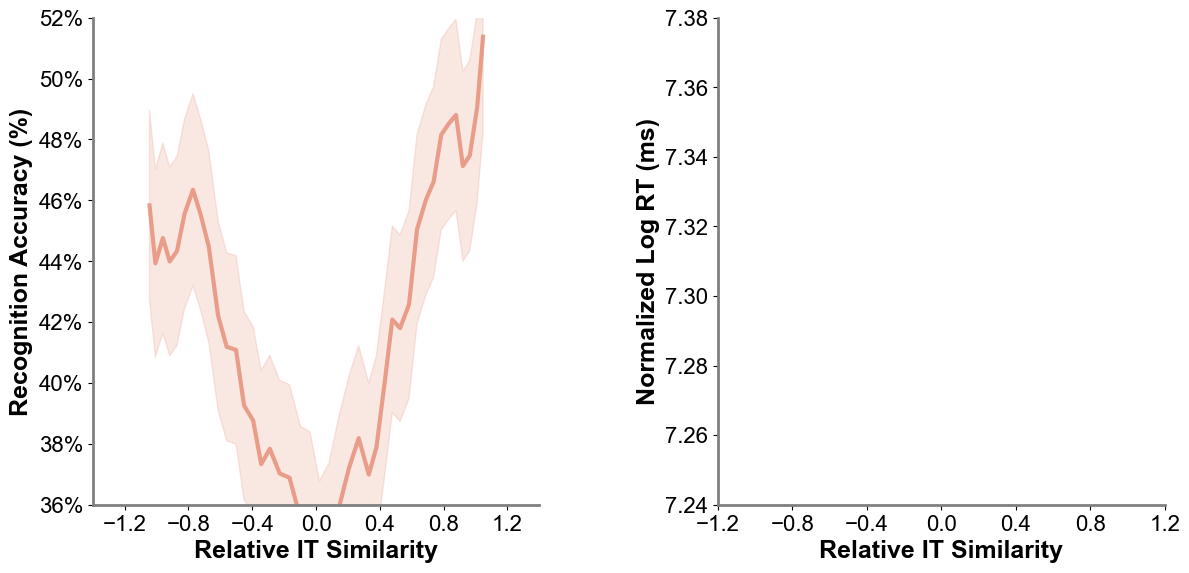

In [105]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter, MultipleLocator

def combined_rolling_average_subplot(df, x_col="Tested - Untested IT Distractor Similarity", 
                                    y_col='Accuracy', item_col=None,
                                    window_percent=0.2, step_percent=0.01,
                                    palette=None, ax=None, show_title=True, show_xlabel=True,
                                    
                                    # Font and color parameters
                                    font_family='Arial', 
                                    title_font_size=16, title_font_color='black', title_font_weight='bold',
                                    label_font_size=14, label_font_color='black', label_font_weight='bold',
                                    tick_font_size=12, tick_font_color='black',  # Changed from 'grey' to 'black'
                                    legend_font_size=10, legend_font_color='black',
                                    
                                    # Axis formatting parameters
                                    y_as_percentage=False, y_percentage_step=2, 
                                    x_tick_step=None, y_tick_step=None,
                                    x_limits=None, y_limits=None,
                                    
                                    # Spacing parameters
                                    line_width=3, confidence_alpha=0.2):
    """
    Enhanced rolling average subplot with customizable fonts, colors, and formatting.
    """
    
    # Use provided axis or create new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 7))
        created_fig = True
    else:
        fig = ax.get_figure()
        created_fig = False
    
    # Set background colors
    if created_fig:
        fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Remove grid
    ax.grid(False)
    
    # Define colors
    grey = '#BFBFBF'
    blue = '#6cbcef'
    teal = '#49a791'
    purple = '#a271b1'
    salmon = '#e58a72'
    gold = '#dbad40'
    green = '#95c355'
    
    if palette is None:
        if "IT Distractor" in x_col:
            palette = [salmon]  # Changed from purple to salmon for IT
        elif "V2 Distractor" in x_col:
            palette = [green]  # Changed from teal to green for V2
        else:
            palette = [purple]  # default
    
    # Color map for specific item types
    color_map = {
        'prioritized': salmon,
        'deprioritized': grey
    }
    
    
    # If splitting by item_col
    if item_col is not None and item_col in df.columns:
        # Get unique tested items
        tested_items = df[item_col].unique()
        
        # Plot rolling averages with labels
        for i, item in enumerate(tested_items):
            df_item = df[df[item_col] == item].sort_values(by=x_col).reset_index(drop=True)
            
            total_points = len(df_item)
            
            window_points = max(int(total_points * window_percent), 3)  # Ensure at least 3 points
            step_points = max(int(total_points * step_percent), 1)      # Ensure at least 1 point
            
            if total_points < window_points:
                print(f"Skipping {item} - insufficient data points ({total_points} < {window_points})")
                continue
                
            print(f"Item: {item}, Total points: {total_points}, Window size: {window_points}, Step size: {step_points}")
                
            x_values = []
            y_values = []
            y_errors = []
            
            for j in range(0, total_points - window_points + 1, step_points):
                window = df_item.iloc[j:j+window_points]
                
                mean_x = window[x_col].mean()
                mean_y = window[y_col].mean()
                
                std_y = window[y_col].std()
                sem_y = std_y / np.sqrt(window_points)
                
                x_values.append(mean_x)
                y_values.append(mean_y)
                y_errors.append(sem_y)
            
            x_values = np.array(x_values)
            y_values = np.array(y_values)
            y_errors = np.array(y_errors)
            
            if len(x_values) == 0:
                continue
            
            # Select color based on item name or index in palette
            item_lower = str(item).lower()
            if item_lower in color_map:
                color = color_map[item_lower]
            elif 'prioritized' in item_lower:
                color = color_map['prioritized']
            elif 'deprioritized' in item_lower:
                color = color_map['deprioritized']
            else:
                # Use palette color with modulo to ensure we don't go out of bounds
                color = palette[i % len(palette)]
            
            # Rolling average lines - now with customizable line width
            ax.plot(x_values, y_values, color=color, linewidth=line_width, alpha=0.8, 
                   label=f'{item}')
            
            # Confidence bands with customizable alpha
            ax.fill_between(x_values, 
                           y_values - 1.96 * y_errors,
                           y_values + 1.96 * y_errors,
                           color=color, alpha=confidence_alpha)
        
        title_suffix = f" by {item_col}"
    
    # If NOT splitting by item_col
    else:
        # Sort by x value
        df_sorted = df.sort_values(by=x_col).reset_index(drop=True)
        
        total_points = len(df_sorted)
        
        window_points = max(int(total_points * window_percent), 3)  # Ensure at least 3 points
        step_points = max(int(total_points * step_percent), 1)      # Ensure at least 1 point
        
        print(f"Total points: {total_points}, Window size: {window_points}, Step size: {step_points}")
            
        x_values = []
        y_values = []
        y_errors = []
        
        for j in range(0, total_points - window_points + 1, step_points):
            window = df_sorted.iloc[j:j+window_points]
            
            mean_x = window[x_col].mean()
            mean_y = window[y_col].mean()
            
            std_y = window[y_col].std()
            sem_y = std_y / np.sqrt(window_points)
            
            x_values.append(mean_x)
            y_values.append(mean_y)
            y_errors.append(sem_y)
        
        x_values = np.array(x_values)
        y_values = np.array(y_values)
        y_errors = np.array(y_errors)
        
        # Use first color from palette
        color = palette[0]
        
        # Rolling average line with customizable line width
        ax.plot(x_values, y_values, color=color, linewidth=line_width, alpha=0.8)
        
        # Confidence bands with customizable alpha
        ax.fill_between(x_values, 
                       y_values - 1.96 * y_errors,
                       y_values + 1.96 * y_errors,
                       color=color, alpha=confidence_alpha)
                
        title_suffix = ""
    
    # Styling for axes and labels with customizable fonts
    if show_xlabel:
        ax.set_xlabel(x_col, fontweight=label_font_weight, fontsize=label_font_size, 
                     color=label_font_color, fontfamily=font_family)
    else:
        ax.set_xlabel('')  # Remove x-axis label
    
    ax.set_ylabel(y_col, fontweight=label_font_weight, fontsize=label_font_size, 
                 color=label_font_color, fontfamily=font_family)
    
    # Custom axis labels with font styling
    if x_col in ["Tested - Untested IT Distractor Similarity", "LTM - NonLTM IT Distractor Similarity"]:
        ax.set_xlabel("Relative IT Similarity", fontweight=label_font_weight, 
                     fontsize=label_font_size, color=label_font_color, fontfamily=font_family)

    if x_col in ["Tested - Untested V2 Distractor Similarity", "LTM - NonLTM V2 Distractor Similarity"]:
        ax.set_xlabel("Relative V2 Similarity", fontweight=label_font_weight, 
                     fontsize=label_font_size, color=label_font_color, fontfamily=font_family)

    # Set y-axis labels and formatting
    if y_col.lower() in ['accuracy', 'ltm accuracy']:
        if y_as_percentage:
            ax.set_ylabel("Recognition Accuracy (%)", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
            # Format y-axis as percentages and set custom ticks
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
            if y_tick_step is None:
                y_tick_step = y_percentage_step / 100.0  # Convert percentage to decimal
        else:
            ax.set_ylabel("Recognition Accuracy (% Correct)", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family)

    if y_col.lower() in ['wm rt', 'ltm rt']:
        ax.set_ylabel("Normalized Log RT (ms)", fontweight=label_font_weight, 
                     fontsize=label_font_size, color=label_font_color, fontfamily=font_family)

    if y_col.lower() in ['error category accuracy']:
        if y_as_percentage:
            ax.set_ylabel("Correct Error Category (%)", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
            # Format y-axis as percentages and set custom ticks
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
            if y_tick_step is None:
                y_tick_step = y_percentage_step / 100.0  # Convert percentage to decimal
        else:
            ax.set_ylabel("Correct Error Category", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
    
    # Set custom tick steps
    if x_tick_step is not None:
        ax.xaxis.set_major_locator(MultipleLocator(x_tick_step))
    
    if y_tick_step is not None:
        ax.yaxis.set_major_locator(MultipleLocator(y_tick_step))
    
    # Set custom axis limits
    if x_limits is not None:
        ax.set_xlim(x_limits)
    
    if y_limits is not None:
        ax.set_ylim(y_limits)
    
    # Style tick labels with custom fonts
    ax.tick_params(axis='x', colors=tick_font_color, labelsize=tick_font_size)
    ax.tick_params(axis='y', colors=tick_font_color, labelsize=tick_font_size)
    
    # Set font family for tick labels
    for label in ax.get_xticklabels():
        label.set_fontfamily(font_family)
    for label in ax.get_yticklabels():
        label.set_fontfamily(font_family)
    
    # Don't create legend at subplot level when not standalone
    if created_fig:
        # Create legend with custom font styling
        legend = ax.legend(frameon=True, fontsize=legend_font_size, loc='center left', 
                          bbox_to_anchor=(1.0, 0.5))
        # Style legend text
        for text in legend.get_texts():
            text.set_fontfamily(font_family)
            text.set_color(legend_font_color)
    
    # Add spines with minimal styling - remove top and right borders
    ax.spines['left'].set_color('grey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_color('grey')
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Only adjust layout if we created the figure
    if created_fig:
        plt.tight_layout()
        plt.subplots_adjust(right=0.8)  # Make room for the legend on the right
    
    return fig


# Enhanced example usage with different dataframes for each plot in a 2x1 grid
plot_configs = [
    {
        'df': df,  # Add dataframe to each config
        'x_col': 'Tested - Untested IT Distractor Similarity',
        'y_col': "LTM Accuracy",
        'item_col': None,
        'y_as_percentage': True,  # Format as percentages
        'y_percentage_step': 2,   # Every 2%
        'y_limits': (0.36, 0.52), # Custom y-axis limits
        'x_limits': (-1.4, 1.4),  # Custom x-axis limits from -1.2 to 1.2
        'x_tick_step': 0.4,       # X-axis ticks every 0.4
        'font_family': 'Arial',
        'label_font_size': 18,    # Increased from 14
        'tick_font_size': 16      # Increased from 12
    },
    {
        'df': df_correct,  # Another dataframe
        'x_col': 'Tested - Untested IT Distractor Similarity',
        'y_col': "LTM RT",
        'item_col': None,
        'y_limits': (7.24, 7.38),
        'y_tick_step': 0.02,  # Custom y-axis step
        'x_limits': (-1.2, 1.2),  # Custom x-axis limits from -1.2 to 1.2
        'x_tick_step': 0.4,       # X-axis ticks every 0.4
        'font_family': 'Arial',
        'label_font_size': 18,    # Increased from 14
        'tick_font_size': 16      # Increased from 12
    }
]

# Create the 2x1 grid with skinnier plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Reduced width from 18 to 12
fig.subplots_adjust(wspace=0.4)  # Maintain horizontal spacing between subplots

# Keep track of all handles and labels for the shared legend
all_handles = []
all_labels = []

for i, config in enumerate(plot_configs):
    combined_rolling_average_subplot(
        config['df'],  # Use the dataframe from config
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config['item_col'],
        window_percent=0.2,
        step_percent=0.02,
        ax=axes[i],
        
        # Pass the custom formatting options
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        y_limits=config.get('y_limits'),
        y_tick_step=config.get('y_tick_step'),
        x_limits=config.get('x_limits'),      # Pass x_limits
        x_tick_step=config.get('x_tick_step'), # Pass x_tick_step
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 18),
        tick_font_size=config.get('tick_font_size', 16)
    )
    
    # Collect handles and labels from this subplot
    handles, labels = axes[i].get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label not in all_labels:  # Only add unique labels
            all_handles.append(handle)
            all_labels.append(label)

# Create one shared legend for the entire figure (only if there are legend items)
if all_handles and all_labels:
    fig.legend(all_handles, all_labels, loc='center', bbox_to_anchor=(0.5, 0.02), 
               ncol=len(all_labels), frameon=True, fontsize=14)  # Increased legend font size

plt.tight_layout()
plt.subplots_adjust(bottom=0.15, wspace=0.4)  # Make room for the shared legend and increase spacing
plt.show()

Total points: 4376, Window size: 875, Step size: 87
Total points: 1890, Window size: 378, Step size: 37


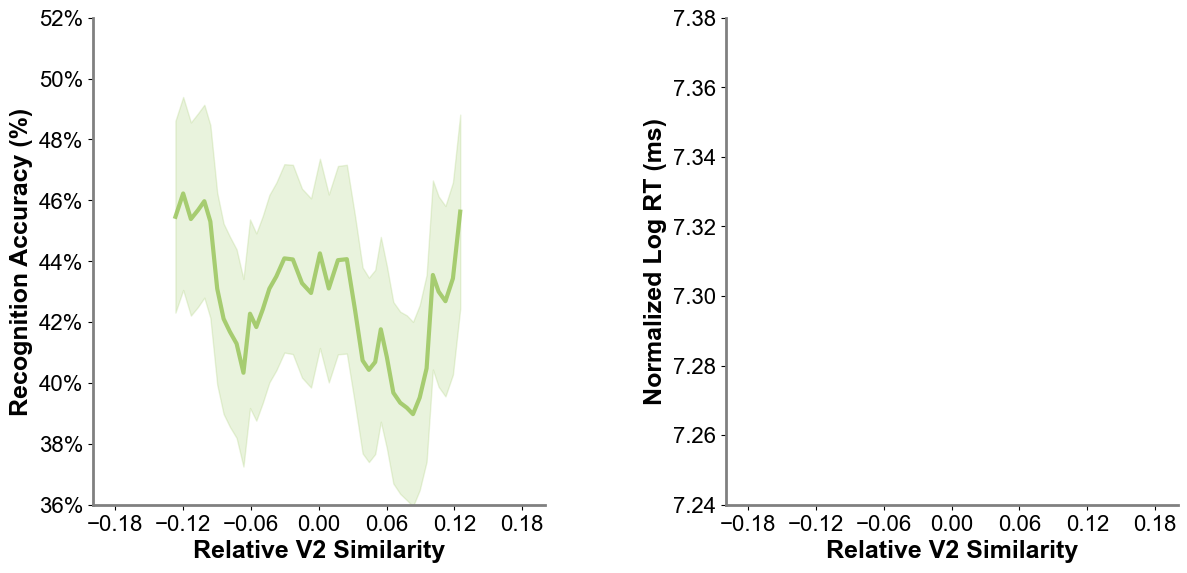

In [106]:
plot_configs = [
    {
        'df': df,  # Add dataframe to each config
        'x_col': 'Tested - Untested V2 Distractor Similarity',
        'y_col': "LTM Accuracy",
        'item_col': None,
        'y_as_percentage': True,  # Format as percentages
        'y_percentage_step': 2,   # Every 2%
        'y_limits': (0.36, 0.52), # Custom y-axis limits
        'x_limits': (-0.2, 0.2),  # Custom x-axis limits from -0.2 to 0.2
        'x_tick_step': 0.06,      # X-axis ticks every 0.04
        'font_family': 'Arial',
        'label_font_size': 18,    # Increased from 14
        'tick_font_size': 16      # Increased from 12
    },
    {
        'df': df_correct,  # Another dataframe
        'x_col': 'Tested - Untested V2 Distractor Similarity',
        'y_col': "LTM RT",
        'item_col': None,
        'y_limits': (7.24, 7.38),
        'y_tick_step': 0.02,  # Custom y-axis step
        'x_limits': (-0.2, 0.2),  # Custom x-axis limits from -0.2 to 0.2
        'x_tick_step': 0.06,      # X-axis ticks every 0.04
        'font_family': 'Arial',
        'label_font_size': 18,    # Increased from 14
        'tick_font_size': 16      # Increased from 12
    }
]

# Create the 2x1 grid with skinnier plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Reduced width from 18 to 12
fig.subplots_adjust(wspace=0.4)  # Maintain horizontal spacing between subplots

# Keep track of all handles and labels for the shared legend
all_handles = []
all_labels = []

for i, config in enumerate(plot_configs):
    combined_rolling_average_subplot(
        config['df'],  # Use the dataframe from config
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config['item_col'],
        window_percent=0.2,
        step_percent=0.02,
        ax=axes[i],
        
        # Pass the custom formatting options
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        y_limits=config.get('y_limits'),
        y_tick_step=config.get('y_tick_step'),
        x_limits=config.get('x_limits'),      # Pass x_limits
        x_tick_step=config.get('x_tick_step'), # Pass x_tick_step
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 18),
        tick_font_size=config.get('tick_font_size', 16)
    )
    
    # Collect handles and labels from this subplot
    handles, labels = axes[i].get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label not in all_labels:  # Only add unique labels
            all_handles.append(handle)
            all_labels.append(label)

# Create one shared legend for the entire figure (only if there are legend items)
if all_handles and all_labels:
    fig.legend(all_handles, all_labels, loc='center', bbox_to_anchor=(0.5, 0.02), 
               ncol=len(all_labels), frameon=True, fontsize=14)  # Increased legend font size

plt.tight_layout()
plt.subplots_adjust(bottom=0.15, wspace=0.4)  # Make room for the shared legend and increase spacing
plt.show()

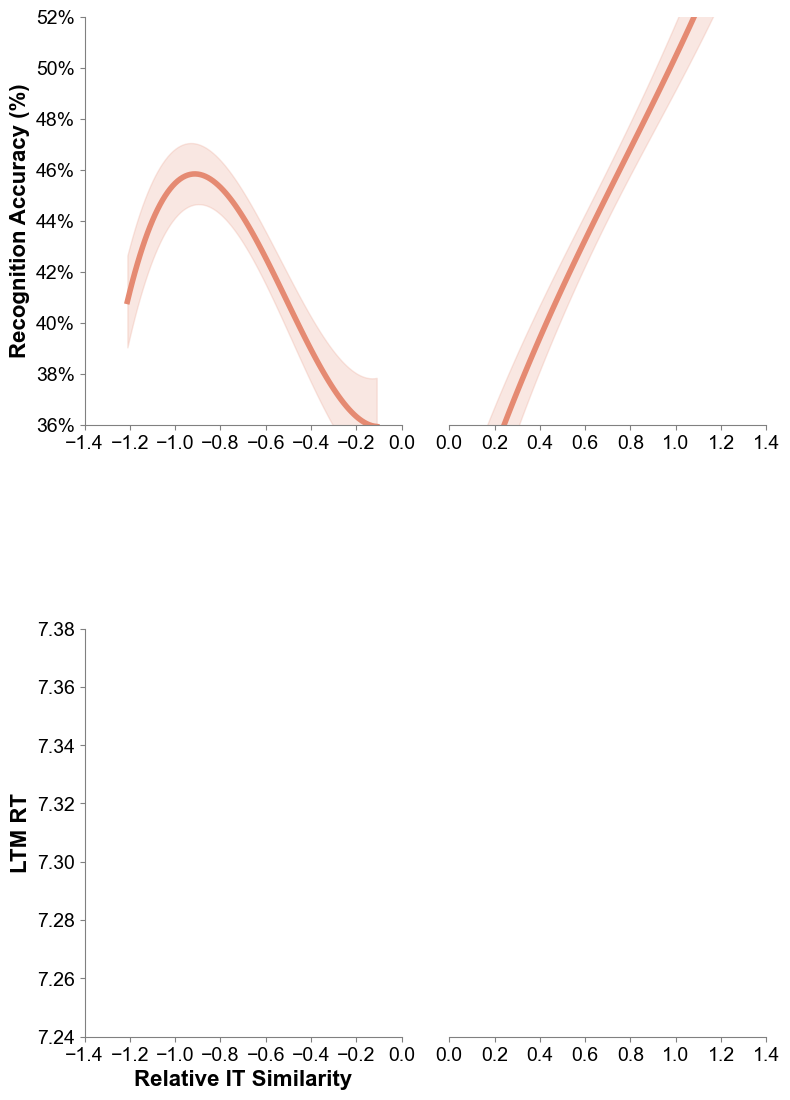

In [107]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from matplotlib.ticker import FuncFormatter, MultipleLocator

def split_order_lmplot_subplot(df, x, y, hue=None, split_value=0, 
                              left_order=2, right_order=2, 
                              ci=68, palette=None, ax_left=None, ax_right=None,
                              show_titles=True, show_xlabel=True,
                              
                              # Font and color parameters
                              font_family='Arial', 
                              title_font_size=18, title_font_color='black', title_font_weight='bold',
                              label_font_size=16, label_font_color='black', label_font_weight='bold',
                              tick_font_size=14, tick_font_color='black',
                              legend_font_size=12, legend_font_color='black',
                              
                              # Axis formatting parameters
                              y_as_percentage=False, y_percentage_step=2, 
                              x_tick_step=None, y_tick_step=None,
                              x_limits=None, y_limits=None,
                              x_limits_left=None, x_limits_right=None,  # NEW: separate limits for each plot
                              
                              # Spacing and visual parameters
                              line_width=4, confidence_alpha=0.2):
    """
    Enhanced split order LMPlot with customizable fonts, colors, and formatting.
    
    Parameters:
    -----------
    df : DataFrame
        Input data
    x, y : str
        Column names for x and y axes
    hue : str, optional
        Column name for grouping
    split_value : float
        Value to split the data at
    left_order, right_order : int
        Polynomial orders for left and right sides
    ci : int
        Confidence interval percentage
    palette : list, optional
        Color palette
    ax_left, ax_right : matplotlib axes, optional
        Axes to plot on
    show_titles, show_xlabel : bool
        Whether to show titles and x-label
    
    Font and color parameters:
    font_family : str
        Font family for all text
    title_font_size, label_font_size, tick_font_size, legend_font_size : int
        Font sizes for different elements
    title_font_color, label_font_color, tick_font_color, legend_font_color : str
        Font colors for different elements
    title_font_weight, label_font_weight : str
        Font weights ('normal', 'bold', etc.)
    
    Axis formatting parameters:
    y_as_percentage : bool
        Whether to format y-axis as percentages
    y_percentage_step : float
        Step size for percentage ticks (e.g., 2 for every 2%)
    x_tick_step, y_tick_step : float, optional
        Custom tick step sizes
    x_limits, y_limits : tuple, optional
        Custom axis limits (min, max) - applied to both plots
    x_limits_left, x_limits_right : tuple, optional
        Custom axis limits for left and right plots separately
    
    Spacing and visual parameters:
    line_width : float
        Width of the regression lines
    confidence_alpha : float
        Alpha value for confidence bands
    """
   
    df_left = df[df[x] <= split_value].copy()
    df_right = df[df[x] > split_value].copy()
    
    if ax_left is not None and ax_right is not None:
        fig = ax_left.get_figure()
        created_fig = False
    else:
        fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
        created_fig = True
    
    if created_fig:
        fig.patch.set_facecolor('white')
    ax_left.set_facecolor('white')
    ax_right.set_facecolor('white')
    
    # Define colors
    grey = '#BFBFBF'
    blue = '#6cbcef'
    teal = '#49a791'
    purple = '#a271b1'
    salmon = '#e58a72'
    gold = '#dbad40'
    green = '#95c355'
    
     
    if palette is None:
        if "IT Distractor" in x:
            palette = [salmon]  # Changed from purple to salmon for IT
        elif "V2 Distractor" in x:
            palette = [green]  # Changed from teal to green for V2
        else:
            palette = [purple]  # default
    
    # Color map for specific item types
    color_map = {
        'prioritized': salmon,
        'deprioritized': grey
    }
    
    # Set up colors
    if hue is not None:
        hue_levels = df[hue].unique()
        color_dict = dict(zip(hue_levels, palette))
    else:
        hue_levels = [None]
        color_dict = {None: palette[0]}

    def plot_side(df_side, ax, order, side_name):
        """Plot one side with specified polynomial order - regression lines only"""
        
        if hue is not None:
            # Plot by hue groups
            for i, hue_val in enumerate(hue_levels):
                if hue_val not in df_side[hue].values:
                    continue
                    
                df_hue = df_side[df_side[hue] == hue_val]
                
                if len(df_hue) < order + 1:
                    print(f"Skipping {hue_val} on {side_name} - insufficient points for order {order}")
                    continue
                
                color = color_dict[hue_val]
                
                # Polynomial fit only
                x_vals = df_hue[x].values
                y_vals = df_hue[y].values
                
                if len(x_vals) >= order + 1:
                    # Create smooth line
                    x_smooth = np.linspace(x_vals.min(), x_vals.max(), 100)
                    
                    # Fit polynomial
                    coeffs = np.polyfit(x_vals, y_vals, order)
                    poly_func = np.poly1d(coeffs)
                    y_smooth = poly_func(x_smooth)
                    
                    # Plot regression line with label and custom line width
                    ax.plot(x_smooth, y_smooth, color=color, linewidth=line_width, 
                           label=hue_val)
                    
                    # Confidence interval
                    if ci > 0:
                        y_pred = poly_func(x_vals)
                        residuals = y_vals - y_pred
                        mse = np.mean(residuals**2)
                        
                        n = len(x_vals)
                        # Standard error calculation
                        x_mean = np.mean(x_vals)
                        ss_x = np.sum((x_vals - x_mean)**2)
                        if ss_x > 0:
                            se = np.sqrt(mse * (1/n + (x_smooth - x_mean)**2 / ss_x))
                        else:
                            se = np.sqrt(mse / n) * np.ones_like(x_smooth)
                        
                        # t-value for confidence interval
                        if ci == 68:
                            t_val = 1.0
                        elif ci == 95:
                            t_val = 1.96
                        else:
                            t_val = stats.t.ppf((100 + ci) / 200, max(n - order - 1, 1))
                        
                        ci_lower = y_smooth - t_val * se
                        ci_upper = y_smooth + t_val * se
                        
                        ax.fill_between(x_smooth, ci_lower, ci_upper, 
                                      color=color, alpha=confidence_alpha)
        else:
            # Single group
            if len(df_side) < order + 1:
                print(f"Insufficient points on {side_name} for order {order}")
                return
            
            color = color_dict[None]
            
            # Polynomial fit only
            x_vals = df_side[x].values
            y_vals = df_side[y].values
            
            # Create smooth line
            x_smooth = np.linspace(x_vals.min(), x_vals.max(), 100)
            
            # Fit polynomial
            coeffs = np.polyfit(x_vals, y_vals, order)
            poly_func = np.poly1d(coeffs)
            y_smooth = poly_func(x_smooth)
            
            # Plot regression line with custom line width
            ax.plot(x_smooth, y_smooth, color=color, linewidth=line_width)
            
            # Confidence interval
            if ci > 0:
                y_pred = poly_func(x_vals)
                residuals = y_vals - y_pred
                mse = np.mean(residuals**2)
                
                n = len(x_vals)
                x_mean = np.mean(x_vals)
                ss_x = np.sum((x_vals - x_mean)**2)
                if ss_x > 0:
                    se = np.sqrt(mse * (1/n + (x_smooth - x_mean)**2 / ss_x))
                else:
                    se = np.sqrt(mse / n) * np.ones_like(x_smooth)
                
                if ci == 68:
                    t_val = 1.0
                elif ci == 95:
                    t_val = 1.96
                else:
                    t_val = stats.t.ppf((100 + ci) / 200, max(n - order - 1, 1))
                
                ci_lower = y_smooth - t_val * se
                ci_upper = y_smooth + t_val * se
                
                ax.fill_between(x_smooth, ci_lower, ci_upper, 
                              color=color, alpha=confidence_alpha)
    
    # Plot both sides
    plot_side(df_left, ax_left, left_order, "Left")
    plot_side(df_right, ax_right, right_order, "Right")
    
    # Styling with custom fonts and colors
    if show_xlabel:
        ax_left.set_xlabel(x, fontweight=label_font_weight, fontsize=label_font_size, 
                          color=label_font_color, fontfamily=font_family)
    else:
        ax_left.set_xlabel('')
    ax_right.set_xlabel('')  # Right plot never gets x-label
    
    ax_left.set_ylabel(y, fontweight=label_font_weight, fontsize=label_font_size, 
                      color=label_font_color, fontfamily=font_family)
    
    # Custom axis labels with font styling
    if x in ["Tested - Untested IT Distractor Similarity"]:
        if show_xlabel:
            ax_left.set_xlabel("Relative IT Similarity", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family)

    if x in ["Tested - Untested V2 Distractor Similarity"]:
        if show_xlabel:
            ax_left.set_xlabel("Relative V2 Similarity", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family)

    # Set y-axis labels and formatting - FIXED: Check if "accuracy" is in the y variable name
    if 'accuracy' in y.lower():
        if y_as_percentage:
            ax_left.set_ylabel("Recognition Accuracy (%)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
            # Format y-axis as percentages and set custom ticks
            ax_left.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
            if y_tick_step is None:
                y_tick_step = y_percentage_step / 100.0  # Convert percentage to decimal
        else:
            ax_left.set_ylabel("Recognition Accuracy (% Correct)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family)

    if y.lower() in ['wm rt']:
        ax_left.set_ylabel("Normalized Log RT (ms)", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family)

    if y.lower() in ['error category accuracy']:
        if y_as_percentage:
            ax_left.set_ylabel("Correct Error Category (%)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
            # Format y-axis as percentages and set custom ticks
            ax_left.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
            if y_tick_step is None:
                y_tick_step = y_percentage_step / 100.0  # Convert percentage to decimal
        else:
            ax_left.set_ylabel("Correct Error Category", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
    
    # Set custom tick steps
    if x_tick_step is not None:
        ax_left.xaxis.set_major_locator(MultipleLocator(x_tick_step))
        ax_right.xaxis.set_major_locator(MultipleLocator(x_tick_step))
    
    if y_tick_step is not None:
        ax_left.yaxis.set_major_locator(MultipleLocator(y_tick_step))
        # ax_right shares y-axis, so no need to set it separately
    
    # Set custom axis limits - separate left/right limits
    if x_limits_left is not None:
        ax_left.set_xlim(x_limits_left)
    elif x_limits is not None:
        ax_left.set_xlim(x_limits)
    
    if x_limits_right is not None:
        ax_right.set_xlim(x_limits_right)
    elif x_limits is not None:
        ax_right.set_xlim(x_limits)
    
    if y_limits is not None:
        ax_left.set_ylim(y_limits)
        ax_right.set_ylim(y_limits)
    
    # Style tick labels with custom fonts (numbers black)
    for ax in [ax_left, ax_right]:
        ax.tick_params(axis='x', colors=tick_font_color, labelsize=tick_font_size)
        ax.tick_params(axis='y', colors=tick_font_color, labelsize=tick_font_size)
        
        # Set font family for tick labels
        for label in ax.get_xticklabels():
            label.set_fontfamily(font_family)
        for label in ax.get_yticklabels():
            label.set_fontfamily(font_family)
    
    # Remove y-axis from right plot
    ax_right.yaxis.set_visible(False)
    ax_right.spines['left'].set_visible(False)
    
    # Set spines to grey but keep numbers black
    spine_color = 'grey'
    for ax in [ax_left, ax_right]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_color(spine_color)
        ax.spines['left'].set_color(spine_color)
        ax.tick_params(axis='x', colors=spine_color)  # x-axis line grey
        ax.tick_params(axis='y', colors=spine_color)  # y-axis line grey
        ax.tick_params(axis='x', labelcolor=tick_font_color)  # x-axis labels black
        ax.tick_params(axis='y', labelcolor=tick_font_color)  # y-axis labels black
        ax.grid(False)  # No grid for clean white look
    
    # Set titles only if requested, with custom font styling and padding
    if show_titles:
        ax_left.set_title(f"{x} ≤ {split_value}", fontsize=title_font_size, 
                         color=title_font_color, fontweight=title_font_weight, 
                         fontfamily=font_family, pad=20)  # Added padding
        ax_right.set_title(f"{x} > {split_value}", fontsize=title_font_size, 
                          color=title_font_color, fontweight=title_font_weight, 
                          fontfamily=font_family, pad=20)  # Added padding
    else:
        ax_left.set_title('')
        ax_right.set_title('')
    
    return fig



# Keep the original 2-plot configuration with same data/ranges, but add x-axis limits and ticks
plot_configs = [
    {
        'df': df,
        'x': 'Tested - Untested IT Distractor Similarity',
        'y': "LTM Accuracy",
        'hue': None,  
        'left_order': 3,
        'right_order': 3,
        'y_as_percentage': True,  # Format as percentages
        'y_percentage_step': 2,   # Every 2%
        'y_limits': (0.36, 0.52), # Original y-axis limits
        'x_tick_step': 0.2,      # X-tick spacing
        'x_limits_left': (-1.4, 0),   # Left plot limits
        'x_limits_right': (0, 1.4),   # Right plot limits
        'font_family': 'Arial',
        'label_font_size': 16,  # Updated to match reference
        'tick_font_size': 14    # Updated to match reference
    },
    {
        'df': df_correct,
        'x': 'Tested - Untested IT Distractor Similarity',
        'y': "LTM RT",
        'hue': None,  
        'left_order': 2,
        'right_order': 3,
        'y_tick_step': 0.02,  # Custom y-axis step
        'y_limits': (7.24, 7.38), # Original y-axis limits
        'x_tick_step': 0.2,      # X-tick spacing
        'x_limits_left': (-1.4, 0),   # Left plot limits
        'x_limits_right': (0, 1.4),   # Right plot limits
        'font_family': 'Arial',
        'label_font_size': 16,  # Updated to match reference
        'tick_font_size': 14    # Updated to match reference
    }
]

# Create 2 rows x 2 columns grid with proportionally adjusted size to match reference ratios
fig, axes = plt.subplots(2, 2, figsize=(8, 12))  # Proportionally adjusted from (8, 18) for 2 rows instead of 3
fig.subplots_adjust(hspace=0.5, wspace=0.15, top=0.95)  # Same spacing ratios as reference

# Set figure background to white
fig.patch.set_facecolor('white')

# Keep track of all handles and labels for shared legend
all_handles = []
all_labels = []

for i, config in enumerate(plot_configs):
    ax_left = axes[i, 0]
    ax_right = axes[i, 1]
    
    split_order_lmplot_subplot(
        df=config['df'],
        x=config['x'],
        y=config['y'],
        hue=config['hue'],
        split_value=0,
        left_order=config['left_order'],
        right_order=config['right_order'],
        ci=68,
        ax_left=ax_left,
        ax_right=ax_right,
        show_titles=False,  # No titles
        show_xlabel=(i == len(plot_configs) - 1),  # Only show x-label on last plot
        
        # Pass the custom formatting options with updated font sizes and x-axis settings
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        y_limits=config.get('y_limits'),
        y_tick_step=config.get('y_tick_step'),
        x_tick_step=config.get('x_tick_step'),        # X-tick spacing
        x_limits_left=config.get('x_limits_left'),   # Left plot limits
        x_limits_right=config.get('x_limits_right'), # Right plot limits
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 16),  # Updated to match reference
        tick_font_size=config.get('tick_font_size', 14),    # Updated to match reference
        title_font_size=18,  # Updated to match reference
        legend_font_size=14  # Updated to match reference
    )
    
    # Collect handles and labels from both subplots
    for ax in [ax_left, ax_right]:
        handles, labels = ax.get_legend_handles_labels()
        for handle, label in zip(handles, labels):
            if label not in all_labels:
                all_handles.append(handle)
                all_labels.append(label)

# Create one shared legend for the entire figure with updated font size
if all_handles:
    fig.legend(all_handles, all_labels, loc='center', bbox_to_anchor=(0.5, 0.02), 
               ncol=len(all_labels), frameon=True, fontsize=14)  # Updated to match reference

plt.tight_layout()
plt.subplots_adjust(bottom=0.1, hspace=0.5, wspace=0.15, top=0.95)  # Same spacing ratios as reference
plt.show()

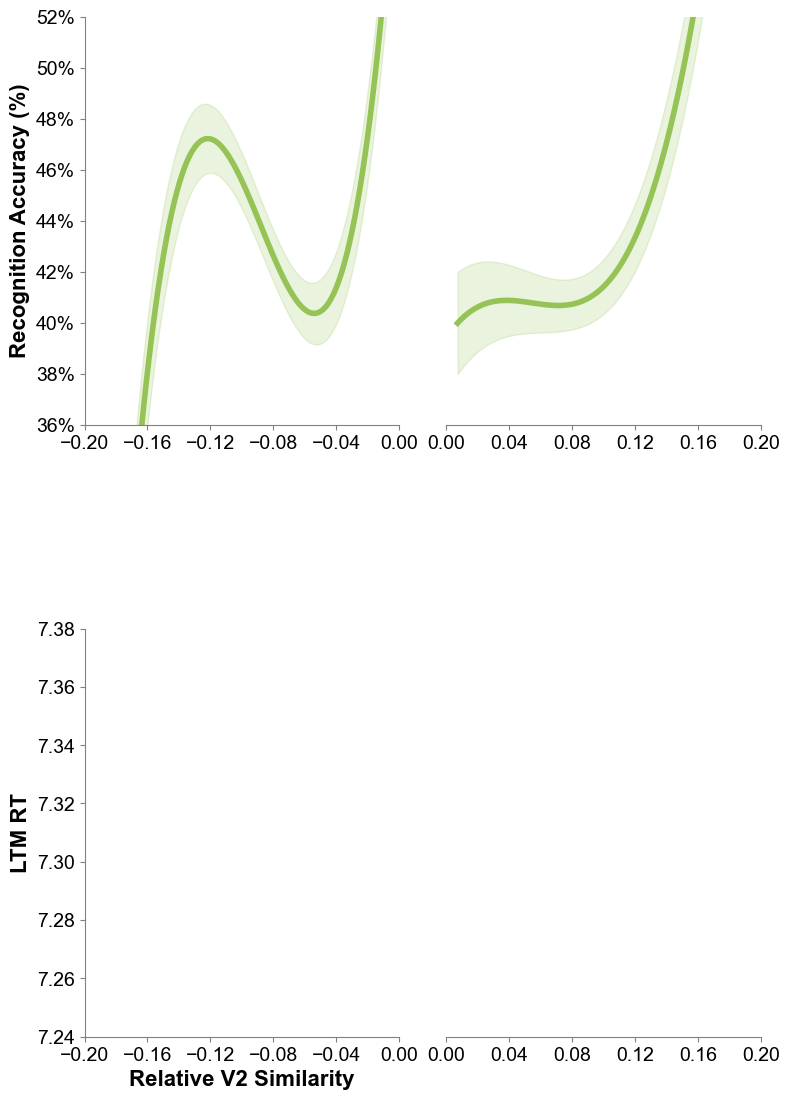

In [108]:


# Keep the original 2-plot configuration with same data/ranges, but add x-axis limits and ticks
plot_configs = [
    {
        'df': df,
        'x': 'Tested - Untested V2 Distractor Similarity',
        'y': "LTM Accuracy",
        'hue': None,  
        'left_order': 3,
        'right_order': 3,
        'y_as_percentage': True,  # Format as percentages
        'y_percentage_step': 2,   # Every 2%
        'y_limits': (0.36, 0.52), # Original y-axis limits
        'x_tick_step': 0.04,      # X-tick spacing
        'x_limits_left': (-0.2, 0),   # Left plot limits
        'x_limits_right': (0, 0.2),   # Right plot limits
        'font_family': 'Arial',
        'label_font_size': 16,  # Updated to match reference
        'tick_font_size': 14    # Updated to match reference
    },
    {
        'df': df_correct,
        'x': 'Tested - Untested V2 Distractor Similarity',
        'y': "LTM RT",
        'hue': None,  
        'left_order': 2,
        'right_order': 3,
        'y_tick_step': 0.02,  # Custom y-axis step
        'y_limits': (7.24, 7.38), # Original y-axis limits
        'x_tick_step': 0.04,      # X-tick spacing
        'x_limits_left': (-0.2, 0),   # Left plot limits
        'x_limits_right': (0, 0.2),   # Right plot limits
        'font_family': 'Arial',
        'label_font_size': 16,  # Updated to match reference
        'tick_font_size': 14    # Updated to match reference
    }
]

# Create 2 rows x 2 columns grid with proportionally adjusted size to match reference ratios
fig, axes = plt.subplots(2, 2, figsize=(8, 12))  # Proportionally adjusted from (8, 18) for 2 rows instead of 3
fig.subplots_adjust(hspace=0.5, wspace=0.15, top=0.95)  # Same spacing ratios as reference

# Set figure background to white
fig.patch.set_facecolor('white')

# Keep track of all handles and labels for shared legend
all_handles = []
all_labels = []

for i, config in enumerate(plot_configs):
    ax_left = axes[i, 0]
    ax_right = axes[i, 1]
    
    split_order_lmplot_subplot(
        df=config['df'],
        x=config['x'],
        y=config['y'],
        hue=config['hue'],
        split_value=0,
        left_order=config['left_order'],
        right_order=config['right_order'],
        ci=68,
        ax_left=ax_left,
        ax_right=ax_right,
        show_titles=False,  # No titles
        show_xlabel=(i == len(plot_configs) - 1),  # Only show x-label on last plot
        
        # Pass the custom formatting options with updated font sizes and x-axis settings
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        y_limits=config.get('y_limits'),
        y_tick_step=config.get('y_tick_step'),
        x_tick_step=config.get('x_tick_step'),        # X-tick spacing
        x_limits_left=config.get('x_limits_left'),   # Left plot limits
        x_limits_right=config.get('x_limits_right'), # Right plot limits
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 16),  # Updated to match reference
        tick_font_size=config.get('tick_font_size', 14),    # Updated to match reference
        title_font_size=18,  # Updated to match reference
        legend_font_size=14  # Updated to match reference
    )
    
    # Collect handles and labels from both subplots
    for ax in [ax_left, ax_right]:
        handles, labels = ax.get_legend_handles_labels()
        for handle, label in zip(handles, labels):
            if label not in all_labels:
                all_handles.append(handle)
                all_labels.append(label)

# Create one shared legend for the entire figure with updated font size
if all_handles:
    fig.legend(all_handles, all_labels, loc='center', bbox_to_anchor=(0.5, 0.02), 
               ncol=len(all_labels), frameon=True, fontsize=14)  # Updated to match reference

plt.tight_layout()
plt.subplots_adjust(bottom=0.1, hspace=0.5, wspace=0.15, top=0.95)  # Same spacing ratios as reference
plt.show()

Locator attempting to generate 25099 ticks ([1446.76, ..., 1948.72]), which exceeds Locator.MAXTICKS (1000).


Negative side - All Data, Total points: 2157, Window size: 431, Step size: 21
  📊 Negative side - All Data Model Fit Exclusions:
     Total points: 2157
     No trimming applied
     Excluded by rolling constraint - Left edge: 204
     Excluded by rolling constraint - Right edge: 182
     Points used in model fit: 1771
     Total excluded: 386
Positive side - All Data, Total points: 2219, Window size: 443, Step size: 22
  📊 Positive side - All Data Model Fit Exclusions:
     Total points: 2219
     No trimming applied
     Excluded by rolling constraint - Left edge: 214
     Excluded by rolling constraint - Right edge: 211
     Points used in model fit: 1794
     Total excluded: 425
Negative side - All Data, Total points: 886, Window size: 177, Step size: 8
  📊 Negative side - All Data Model Fit Exclusions:
     Total points: 886
     No trimming applied
     Excluded by rolling constraint - Left edge: 85
     Excluded by rolling constraint - Right edge: 81
     Points used in model fi

Locator attempting to generate 25099 ticks ([1446.76, ..., 1948.72]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 25099 ticks ([1446.76, ..., 1948.72]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 25099 ticks ([1446.76, ..., 1948.72]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 25099 ticks ([1446.76, ..., 1948.72]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 25099 ticks ([1446.76, ..., 1948.72]), which exceeds Locator.MAXTICKS (1000).


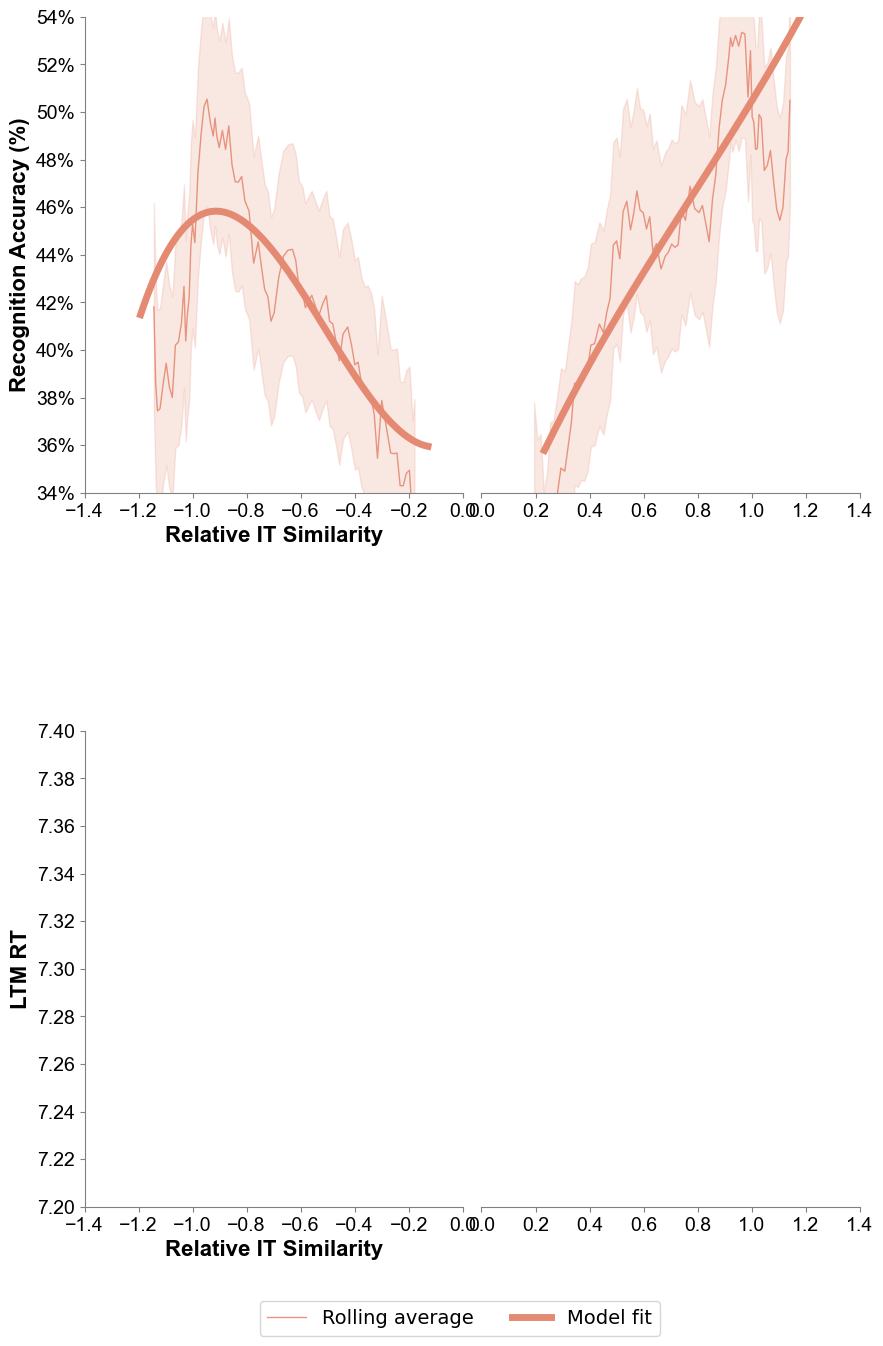

In [109]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter, MultipleLocator

def combined_sliding_window_and_model_fit_split_col_subplot(df, x_col="Tested - Untested V2 Distractor Similarity", 
                                               y_col='Accuracy', item_col=None,
                                               split_col='v2_pos_neg', split_value=0,
                                               window_percent=0.2, step_percent=0.02,
                                               palette=None, aspect=0.7, figsize_height=6,
                                               ax_left=None, ax_right=None,
                                               y_limits=None, share_y=True,
                                               
                                               # Model fit order parameters
                                               left_model_order=2, right_model_order=2,
                                               
                                               # Robust regression options
                                               trim_percentile=0,  # Trim extreme percentiles (0 = no trim)
                                               
                                               # Font and color parameters
                                               font_family='Arial', 
                                               title_font_size=18, title_font_color='black', title_font_weight='bold',
                                               label_font_size=16, label_font_color='black', label_font_weight='bold',
                                               tick_font_size=14, tick_font_color='black',
                                               legend_font_size=14, legend_font_color='black',
                                               
                                               # Axis formatting parameters
                                               y_as_percentage=False, y_percentage_step=2, 
                                               x_tick_step=None, y_tick_step=None,
                                               x_limits=None,
                                               x_limits_left=None, x_limits_right=None,
                                               
                                               # Visual parameters
                                               rolling_line_width=1, model_line_width=5, 
                                               confidence_alpha=0.2, rolling_alpha=0.9,
                                               
                                               # Title control
                                               show_titles=True):
    """
    Enhanced sliding window and model fit with customizable fonts, colors, and robust options.
    
    Parameters:
    -----------
    df : DataFrame
        Input data
    x_col, y_col : str
        Column names for x and y axes
    item_col : str, optional
        Column name for grouping items
    split_col : str
        Column name for splitting data
    split_value : float
        Value to split the data at
    window_percent, step_percent : float
        Rolling window parameters
    palette : list, optional
        Color palette
    aspect, figsize_height : float
        Figure dimensions
    ax_left, ax_right : matplotlib axes, optional
        Axes to plot on
    y_limits : tuple, optional
        Custom y-axis limits
    share_y : bool
        Whether to share y-axis between subplots
    
    Model fit order parameters:
    left_model_order, right_model_order : int
        Polynomial orders for left and right side model fits
    
    Robust regression options:
    trim_percentile : float
        Remove extreme percentiles before fitting (e.g., 5 removes top/bottom 5%)
    
    Font and color parameters:
    font_family : str
        Font family for all text
    title_font_size, label_font_size, tick_font_size, legend_font_size : int
        Font sizes for different elements
    title_font_color, label_font_color, tick_font_color, legend_font_color : str
        Font colors for different elements
    title_font_weight, label_font_weight : str
        Font weights ('normal', 'bold', etc.)
    
    Axis formatting parameters:
    y_as_percentage : bool
        Whether to format y-axis as percentages
    y_percentage_step : float
        Step size for percentage ticks (e.g., 2 for every 2%)
    x_tick_step, y_tick_step : float, optional
        Custom tick step sizes
    x_limits : tuple, optional
        Custom x-axis limits (applies to both sides if x_limits_left/right not specified)
    x_limits_left, x_limits_right : tuple, optional
        Custom x-axis limits for left and right plots separately
    
    Visual parameters:
    rolling_line_width, model_line_width : float
        Line widths for rolling average and model fit
    confidence_alpha, rolling_alpha : float
        Alpha values for confidence bands and rolling lines
    
    Title control:
    show_titles : bool
        Whether to show subplot titles
    """
   
    # Define colors
    grey = '#BFBFBF'
    blue = '#6cbcef'
    teal = '#49a791'
    purple = '#a271b1'
    salmon = '#e58a72'
    gold = '#dbad40'
    green = '#95c355'
    
    # Auto-select color based on x column if no palette provided
    if palette is None:
        if "IT Distractor" in x_col:
            palette = [salmon]  # Changed from purple to salmon for IT
        elif "V2 Distractor" in x_col:
            palette = [green]  # Changed from teal to green for V2
        else:
            palette = [purple]  # default
    
    # Color map for specific item types
    color_map = {
        'prioritized': salmon,
        'deprioritized': grey
    }

    
    # Split the data
    df_left = df[df[x_col] <= split_value].copy()
    df_right = df[df[x_col] > split_value].copy()
    
    # If axes are provided, use them; otherwise create new figure
    if ax_left is not None and ax_right is not None:
        # Use provided axes
        fig = ax_left.get_figure()
        created_fig = False
    else:
        # Calculate figure width based on height and aspect ratio
        figsize_width = 2 * figsize_height * aspect  # 2 panels * height * aspect
        
        # Create figure with specified dimensions
        fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(figsize_width, figsize_height), 
                                                 sharey=share_y)
        created_fig = True
    
    # Set background colors
    if created_fig:
        fig.patch.set_facecolor('white')
    ax_left.set_facecolor('white')
    ax_right.set_facecolor('white')
    
    # Create a consistent item to color mapping using ALL data (not just one side)
    item_color_dict = {}
    if item_col is not None and item_col in df.columns:
        # Get all unique items from the entire dataset
        all_items = df[item_col].unique()
        
        # Create color mapping for all items
        for i, item in enumerate(all_items):
            item_lower = str(item).lower()
            if item_lower in color_map:
                item_color_dict[item] = color_map[item_lower]
            elif 'prioritized' in item_lower:
                item_color_dict[item] = color_map['prioritized']
            elif 'deprioritized' in item_lower:
                item_color_dict[item] = color_map['deprioritized']
            else:
                item_color_dict[item] = palette[i % len(palette)]
    
    # Function to process data for each side
    def process_side(df_side, ax, side_name, model_order, group_by_item=True):
        if group_by_item and item_col is not None and item_col in df.columns:
            # Process by item groups
            items = df_side[item_col].unique()
            
            # First, plot rolling averages (in background) - NO TRIMMING
            for i, item in enumerate(items):
                df_item = df_side[df_side[item_col] == item].copy()
                df_item = df_item.sort_values(by=x_col).reset_index(drop=True)
                total_points = len(df_item)
                
                # Calculate window and step sizes for THIS SPECIFIC ITEM
                window_points = max(int(total_points * window_percent), 3)  # Ensure at least 3 points
                step_points = max(int(total_points * step_percent), 1)      # Ensure at least 1 point
                
                # Get color from the consistent global mapping
                color = item_color_dict.get(item, palette[i % len(palette)])
                
                # Add rolling average if enough points (using ALL data, no trimming)
                if total_points >= window_points:
                    print(f"{side_name} side - {item}, Total points: {total_points}, "
                          f"Window size: {window_points}, Step size: {step_points}")
                        
                    x_vals, y_vals, y_errs = [], [], []
                    
                    for j in range(0, total_points - window_points + 1, step_points):
                        window = df_item.iloc[j:j+window_points]
                        
                        mean_x = window[x_col].mean()
                        mean_y = window[y_col].mean()
                        std_y = window[y_col].std()
                        sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                        
                        x_vals.append(mean_x)
                        y_vals.append(mean_y)
                        y_errs.append(sem_y)
                    
                    x_vals = np.array(x_vals)
                    y_vals = np.array(y_vals)
                    y_errs = np.array(y_errs)
                    
                    if len(x_vals) > 0:
                        # Rolling average with custom line width and alpha
                        ax.plot(x_vals, y_vals, color=color, linewidth=rolling_line_width, 
                               alpha=rolling_alpha, label=f'{item} (rolling)')
                        
                        # Confidence bands with custom alpha
                        ax.fill_between(x_vals, 
                                       y_vals - 1.96 * y_errs,
                                       y_vals + 1.96 * y_errs,
                                       color=color, alpha=confidence_alpha)
            
            # Then plot model fits (bold lines on top) - WITH TRIMMING
            for i, item in enumerate(items):
                df_item = df_side[df_side[item_col] == item].copy()
                
                # Apply trim_percentile ONLY for model fit
                if trim_percentile > 0:
                    lower_p = np.percentile(df_item[x_col], trim_percentile)
                    upper_p = np.percentile(df_item[x_col], 100 - trim_percentile)
                    df_item_trimmed = df_item[(df_item[x_col] >= lower_p) & (df_item[x_col] <= upper_p)]
                else:
                    df_item_trimmed = df_item
                
                total_points = len(df_item_trimmed)
                
                # Get color from the consistent global mapping
                color = item_color_dict.get(item, palette[i % len(palette)])
                
                # Add model fit if enough points
                if total_points >= 5:  # Need at least 5 points for a reasonable quadratic fit
                    # Calculate the effective range where rolling average can exist
                    total_points_full = len(df_item)
                    window_points_full = max(int(total_points_full * window_percent), 3)
                    
                    # Rolling average can only exist where there are enough points for a window
                    # So it starts at window_points_full//2 and ends at -(window_points_full//2)
                    df_item_sorted = df_item.sort_values(by=x_col)
                    rolling_min_x = df_item_sorted.iloc[window_points_full//2][x_col]
                    rolling_max_x = df_item_sorted.iloc[-(window_points_full//2 + 1)][x_col]
                    
                    # Count points excluded by rolling average constraint (before trimming)
                    points_below_rolling = len(df_item_trimmed[df_item_trimmed[x_col] < rolling_min_x])
                    points_above_rolling = len(df_item_trimmed[df_item_trimmed[x_col] > rolling_max_x])
                    
                    # Constrain model fit range to not exceed rolling average range
                    model_min_x = max(df_item_trimmed[x_col].min(), rolling_min_x)
                    model_max_x = min(df_item_trimmed[x_col].max(), rolling_max_x)
                    
                    # Count points actually used in model fit
                    points_in_model = len(df_item_trimmed[
                        (df_item_trimmed[x_col] >= model_min_x) & 
                        (df_item_trimmed[x_col] <= model_max_x)
                    ])
                    
                    # Count points excluded by trimming
                    points_excluded_by_trim = len(df_item) - len(df_item_trimmed)
                    
                    # Print exclusion report
                    print(f"  📊 {side_name} side - {item} Model Fit Exclusions:")
                    print(f"     Total points: {len(df_item)}")
                    
                    if trim_percentile > 0:
                        print(f"     Excluded by trimming ({trim_percentile}%): {points_excluded_by_trim}")
                        print(f"     Remaining after trim: {len(df_item_trimmed)}")
                    else:
                        print(f"     No trimming applied")
                    
                    print(f"     Excluded by rolling constraint - Left edge: {points_below_rolling}")
                    print(f"     Excluded by rolling constraint - Right edge: {points_above_rolling}")
                    print(f"     Points used in model fit: {points_in_model}")
                    print(f"     Total excluded: {len(df_item) - points_in_model}")
                    
                    # Only plot if we have a valid range
                    if model_max_x > model_min_x:
                        x_range = np.linspace(model_min_x, model_max_x, 100)
                        model = np.poly1d(np.polyfit(df_item_trimmed[x_col], df_item_trimmed[y_col], model_order))
                        
                        # Bold model fit lines with custom line width
                        ax.plot(x_range, model(x_range), color=color, linestyle='-', 
                                linewidth=model_line_width, label=f'{item} (model)')
        else:
            # Process all data as one group
            df_side_copy = df_side.copy()
            df_side_copy = df_side_copy.sort_values(by=x_col).reset_index(drop=True)
            total_points = len(df_side_copy)
            
            # Calculate window and step sizes for ALL DATA
            window_points = max(int(total_points * window_percent), 3)  # Ensure at least 3 points
            step_points = max(int(total_points * step_percent), 1)      # Ensure at least 1 point
            
            # Use first color from palette
            color = palette[0]
            
            # First plot rolling average (background) - NO TRIMMING, use all data
            if total_points >= window_points:
                print(f"{side_name} side - All Data, Total points: {total_points}, "
                      f"Window size: {window_points}, Step size: {step_points}")
                    
                x_vals, y_vals, y_errs = [], [], []
                
                for j in range(0, total_points - window_points + 1, step_points):
                    window = df_side_copy.iloc[j:j+window_points]
                    
                    mean_x = window[x_col].mean()
                    mean_y = window[y_col].mean()
                    std_y = window[y_col].std()
                    sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                    
                    x_vals.append(mean_x)
                    y_vals.append(mean_y)
                    y_errs.append(sem_y)
                
                x_vals = np.array(x_vals)
                y_vals = np.array(y_vals)
                y_errs = np.array(y_errs)
                
                if len(x_vals) > 0:
                    # Rolling average with custom styling
                    ax.plot(x_vals, y_vals, color=color, linewidth=rolling_line_width, 
                           alpha=rolling_alpha, label='Rolling average')
                    
                    # Confidence bands with custom alpha
                    ax.fill_between(x_vals, 
                                   y_vals - 1.96 * y_errs,
                                   y_vals + 1.96 * y_errs,
                                   color=color, alpha=confidence_alpha)
            
            # Then plot model fit (bold, on top) - WITH TRIMMING
            # Apply trim_percentile ONLY for model fit
            if trim_percentile > 0:
                lower_p = np.percentile(df_side_copy[x_col], trim_percentile)
                upper_p = np.percentile(df_side_copy[x_col], 100 - trim_percentile)
                df_side_trimmed = df_side_copy[(df_side_copy[x_col] >= lower_p) & (df_side_copy[x_col] <= upper_p)]
            else:
                df_side_trimmed = df_side_copy
            
            total_points_trimmed = len(df_side_trimmed)
            
            if total_points_trimmed >= 5:  # Need at least 5 points for a reasonable quadratic fit
                # Calculate the effective range where rolling average can exist
                window_points_full = max(int(total_points * window_percent), 3)
                
                # Rolling average can only exist where there are enough points for a window
                df_side_sorted = df_side_copy.sort_values(by=x_col)
                rolling_min_x = df_side_sorted.iloc[window_points_full//2][x_col]
                rolling_max_x = df_side_sorted.iloc[-(window_points_full//2 + 1)][x_col]
                
                # Count points excluded by rolling average constraint (before trimming)
                points_below_rolling = len(df_side_trimmed[df_side_trimmed[x_col] < rolling_min_x])
                points_above_rolling = len(df_side_trimmed[df_side_trimmed[x_col] > rolling_max_x])
                
                # Constrain model fit range to not exceed rolling average range
                model_min_x = max(df_side_trimmed[x_col].min(), rolling_min_x)
                model_max_x = min(df_side_trimmed[x_col].max(), rolling_max_x)
                
                # Count points actually used in model fit
                points_in_model = len(df_side_trimmed[
                    (df_side_trimmed[x_col] >= model_min_x) & 
                    (df_side_trimmed[x_col] <= model_max_x)
                ])
                
                # Count points excluded by trimming
                points_excluded_by_trim = len(df_side_copy) - len(df_side_trimmed)
                
                # Print exclusion report
                print(f"  📊 {side_name} side - All Data Model Fit Exclusions:")
                print(f"     Total points: {len(df_side_copy)}")
                
                if trim_percentile > 0:
                    print(f"     Excluded by trimming ({trim_percentile}%): {points_excluded_by_trim}")
                    print(f"     Remaining after trim: {len(df_side_trimmed)}")
                else:
                    print(f"     No trimming applied")
                
                print(f"     Excluded by rolling constraint - Left edge: {points_below_rolling}")
                print(f"     Excluded by rolling constraint - Right edge: {points_above_rolling}")
                print(f"     Points used in model fit: {points_in_model}")
                print(f"     Total excluded: {len(df_side_copy) - points_in_model}")
                
                # Only plot if we have a valid range
                if model_max_x > model_min_x:
                    x_range = np.linspace(model_min_x, model_max_x, 100)
                    model = np.poly1d(np.polyfit(df_side_trimmed[x_col], df_side_trimmed[y_col], model_order))
                    
                    # Bold model fit line with custom line width
                    ax.plot(x_range, model(x_range), color=color, linestyle='-', 
                            linewidth=model_line_width, label='Model fit')
    
    # Process both sides with different model orders
    use_item_col = (item_col is not None and item_col in df.columns)
    process_side(df_left, ax_left, "Negative", left_model_order, use_item_col)
    process_side(df_right, ax_right, "Positive", right_model_order, use_item_col)
    
    # Set titles and labels with custom font styling - only if show_titles is True
    if show_titles:
        ax_left.set_title(f"{x_col} ≤ {split_value}", fontsize=title_font_size, 
                         color=title_font_color, fontweight=title_font_weight, 
                         fontfamily=font_family, pad=20)
        ax_right.set_title(f"{x_col} > {split_value}", fontsize=title_font_size, 
                          color=title_font_color, fontweight=title_font_weight, 
                          fontfamily=font_family, pad=20)

    # Custom axis labels with font styling - only on left side
    if x_col in ["Tested - Untested IT Distractor Similarity"]:
        ax_left.set_xlabel("Relative IT Similarity", fontweight=label_font_weight, 
                          fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
    elif x_col in ["Tested - Untested V2 Distractor Similarity"]:
        ax_left.set_xlabel("Relative V2 Similarity", fontweight=label_font_weight, 
                          fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
    else:
        ax_left.set_xlabel(x_col, fontweight=label_font_weight, fontsize=label_font_size, 
                          color=label_font_color, fontfamily=font_family)
    
    # Set y-axis labels and formatting for left side only
    if y_col.lower() in ['accuracy', 'ltm accuracy']:
        if y_as_percentage:
            ax_left.set_ylabel("Recognition Accuracy (%)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
            # Format y-axis as percentages - only for left side
            ax_left.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
            if y_tick_step is None:
                y_tick_step = y_percentage_step / 100.0  # Convert percentage to decimal
        else:
            ax_left.set_ylabel("Recognition Accuracy (% Correct)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
    elif y_col.lower() in ['wm rt']:
        ax_left.set_ylabel("Normalized Log RT (ms)", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
    elif y_col.lower() in ['error category accuracy']:
        if y_as_percentage:
            ax_left.set_ylabel("Correct Error Category (%)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
            # Format y-axis as percentages - only for left side
            ax_left.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
            if y_tick_step is None:
                y_tick_step = y_percentage_step / 100.0  # Convert percentage to decimal
        else:
            ax_left.set_ylabel("Correct Error Category", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
    else:
        ax_left.set_ylabel(y_col, fontweight=label_font_weight, fontsize=label_font_size, 
                         color=label_font_color, fontfamily=font_family)
    
    # Set custom tick steps for both axes
    if x_tick_step is not None:
        ax_left.xaxis.set_major_locator(MultipleLocator(x_tick_step))
        ax_right.xaxis.set_major_locator(MultipleLocator(x_tick_step))
    
    if y_tick_step is not None:
        ax_left.yaxis.set_major_locator(MultipleLocator(y_tick_step))
        if not share_y:  # Only apply to right if y-axis is visible
            ax_right.yaxis.set_major_locator(MultipleLocator(y_tick_step))
    
    # Set custom axis limits
    if x_limits_left is not None:
        ax_left.set_xlim(x_limits_left)
    elif x_limits is not None:
        ax_left.set_xlim(x_limits)
    
    if x_limits_right is not None:
        ax_right.set_xlim(x_limits_right)
    elif x_limits is not None:
        ax_right.set_xlim(x_limits)
    
    # Style tick labels with custom fonts (numbers black, axis lines grey)
    spine_color = 'grey'
    for ax in [ax_left, ax_right]:
        ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size)
        ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size)
        ax.tick_params(axis='x', labelcolor=tick_font_color)  # x-axis labels black
        ax.tick_params(axis='y', labelcolor=tick_font_color)  # y-axis labels black
        
        # Set font family for tick labels
        for label in ax.get_xticklabels():
            label.set_fontfamily(font_family)
        for label in ax.get_yticklabels():
            label.set_fontfamily(font_family)
    
    # Style the axes - make y-axis invisible on right side
    if share_y:
        ax_right.yaxis.set_visible(False)
        ax_right.spines['left'].set_visible(False)
    
    # Set spine colors to grey
    for ax in [ax_left, ax_right]:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_color(spine_color)
        ax.spines['left'].set_color(spine_color)
    
    # Make sure both plots have the same y-axis scale but only left shows labels
    if not share_y:
        # If not sharing y, make sure right plot has same y-axis label
        if y_col.lower() in ['accuracy', 'ltm accuracy']:
            if y_as_percentage:
                ax_right.set_ylabel("Recognition Accuracy (%)", fontweight=label_font_weight, 
                                   fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
                ax_right.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
            else:
                ax_right.set_ylabel("Recognition Accuracy (% Correct)", fontweight=label_font_weight, 
                                   fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
        elif y_col.lower() in ['wm rt']:
            ax_right.set_ylabel("Normalized Log RT (ms)", fontweight=label_font_weight, 
                               fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
        elif y_col.lower() in ['error category accuracy']:
            if y_as_percentage:
                ax_right.set_ylabel("Correct Error Category (%)", fontweight=label_font_weight, 
                                   fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
                ax_right.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
            else:
                ax_right.set_ylabel("Correct Error Category", fontweight=label_font_weight, 
                                   fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
        else:
            ax_right.set_ylabel(y_col, fontweight=label_font_weight, fontsize=label_font_size, 
                               color=label_font_color, fontfamily=font_family)
    
    # Remove grid
    ax_left.grid(False)
    ax_right.grid(False)

    # Set y-limits based on y_limits parameter or y_col type
    if y_limits is not None:
        ax_left.set_ylim(y_limits)
        ax_right.set_ylim(y_limits)  # Apply to both sides
    elif y_col.lower() in ['accuracy', 'acc', 'correct', 'resp_correct', 'ltm accuracy']:
        ax_left.set_ylim(0.6, 0.8)
        ax_right.set_ylim(0.6, 0.8)  # Apply to both sides
    
    # Add legend to right plot - only keep unique items by using set()
    by_label = {}
    for ax in [ax_left, ax_right]:
        handles, labels = ax.get_legend_handles_labels()
        # Group handles by labels and take the first handle for each label
        for h, lbl in zip(handles, labels):
            # Just use the item name without the "(rolling)" or "(model)" suffix
            if "(" in lbl:
                base_label = lbl.split("(")[0].strip()
            else:
                base_label = lbl
            if base_label not in by_label:
                by_label[base_label] = h
    
    # Place legend outside and below the plot if we created the figure
    if by_label and created_fig:
        legend = fig.legend(by_label.values(), by_label.keys(), 
                          loc='lower center', ncol=len(by_label), bbox_to_anchor=(0.5, -0.05),
                          fontsize=legend_font_size)
        # Style legend text
        for text in legend.get_texts():
            text.set_fontfamily(font_family)
            text.set_color(legend_font_color)
    
    # Add main title if we created the figure
    if created_fig:
        window_percent_text = f"{window_percent*100:.0f}%"
        title_suffix = f" by {item_col}" if use_item_col else ""
        fig.suptitle(f'Rolling Average and Model Fit{title_suffix}', 
                     fontweight=title_font_weight, fontsize=title_font_size, y=0.98,
                     color=title_font_color, fontfamily=font_family)
        
        plt.subplots_adjust(bottom=0.15)  # Make room for the legend
    
    return fig


# Enhanced example usage with robust options and custom styling
y_limits_dict = {
    'Accuracy': (0.7, 0.8),
    'WM RT': (7.26, 7.34),  # Adjust these based on your RT scale
    'Error Category Accuracy': (0.52, 0.69)  # Adjust based on your error scale
}

# Updated plot_configs with only 2 configurations (removed the duplicate third one)
plot_configs = [
    {
        'df': df,
        'x_col': 'Tested - Untested IT Distractor Similarity',
        'y_col': "LTM Accuracy",
        # 'item_col': "Tested Item",
        'split_col': "IT_pos_neg",
        'split_value': 0,
        'y_limits': (0.34, 0.54), # Custom y-axis limits
        'x_limits_left': (-1.4, 0),   # Left plot x-axis range
        'x_limits_right': (0, 1.4),   # Right plot x-axis range
        'x_tick_step': 0.2,           # X-axis ticks every 0.2
        'left_model_order': 3,         # 2nd order polynomial for left side
        'right_model_order': 3,        # 3rd order polynomial for right side
        'trim_percentile': 0,          # Remove extreme 3% from each tail
        'y_as_percentage': True,       # Format as percentages
        'y_percentage_step': 2,        # Every 4%
        'font_family': 'Arial',
        'label_font_size': 16,         # Increased from 14
        'tick_font_size': 14           # Increased from 12
    },
    {
        'df': df_correct,
        'x_col': 'Tested - Untested IT Distractor Similarity',
        'y_col': "LTM RT",
        # 'item_col': "Tested Item",
        'split_col': "IT_pos_neg",
        'split_value': 0,
        'y_limits': (7.2, 7.4), # Custom y-axis limits
        'x_limits_left': (-1.4, 0),   # Left plot x-axis range
        'x_limits_right': (0, 1.4),   # Right plot x-axis range
        'x_tick_step': 0.2,           # X-axis ticks every 0.2
        'left_model_order': 2,         # 1st order (linear) for left side
        'right_model_order': 3,        # 2nd order for right side
        'trim_percentile': 0,          # Remove extreme 5% from each tail
        'y_tick_step': 0.02,           # Custom y-axis step
        'font_family': 'Arial',
        'label_font_size': 16,         # Increased from 14
        'tick_font_size': 14           # Increased from 12
    }
]

# Create a 2x2 grid with y-axes shared by row and reduced width
fig, axes = plt.subplots(2, 2, figsize=(10, 14), sharey='row')  # Changed from 3x2 to 2x2, height from 20 to 14
fig.subplots_adjust(hspace=0.5, wspace=0.05, top=0.95)  # Reduced wspace from 0.15 to 0.05

# Keep track of all handles and labels for a shared legend
all_handles = []
all_labels = []

# Iterate through rows (now only 2 rows instead of 3)
for i, config in enumerate(plot_configs):
    row = i
    ax_left = axes[row, 0]
    ax_right = axes[row, 1]
    
    combined_sliding_window_and_model_fit_split_col_subplot(
        config['df'],
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config.get('item_col'),  # Use get to handle missing keys
        split_col=config['split_col'],
        split_value=config['split_value'],
        window_percent=0.2,
        step_percent=0.01,
        ax_left=ax_left,  # Pass the axes
        ax_right=ax_right,  # Pass the axes
        y_limits=config.get('y_limits', None),
        x_limits_left=config.get('x_limits_left', None),   # New parameter
        x_limits_right=config.get('x_limits_right', None), # New parameter
        x_tick_step=config.get('x_tick_step', None),       # X-tick step parameter
        share_y=True,
        
        # Model fit orders
        left_model_order=config.get('left_model_order', 1),
        right_model_order=config.get('right_model_order', 2),
        
        # Robust and styling options
        trim_percentile=config.get('trim_percentile', 0),
        y_as_percentage=config.get('y_as_percentage', False),  # UNCOMMENTED THIS LINE
        y_percentage_step=config.get('y_percentage_step', 2),
        y_tick_step=config.get('y_tick_step'),
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 16),    # Increased default
        tick_font_size=config.get('tick_font_size', 14),      # Increased default
        title_font_size=18,                                   # Increased from 16
        legend_font_size=14,                                  # Increased from 12
        show_titles=False                                     # No titles
    )
    
    # Collect handles and labels from both subplots
    for ax in [ax_left, ax_right]:
        handles, labels = ax.get_legend_handles_labels()
        for handle, label in zip(handles, labels):
            # Clean up label to remove (rolling) or (model) suffix
            if "(" in label:
                base_label = label.split("(")[0].strip()
            else:
                base_label = label
            if base_label not in all_labels:
                all_handles.append(handle)
                all_labels.append(base_label)

# Create one shared legend for the entire figure
if all_handles:
    fig.legend(all_handles, all_labels, loc='center', bbox_to_anchor=(0.5, 0.02), 
               ncol=len(all_labels), frameon=True, fontsize=14)  # Increased legend font size

# Manual layout adjustment (no tight_layout needed since we're using sharey and manual spacing)
plt.subplots_adjust(bottom=0.1, hspace=0.5, wspace=0.05, top=0.95)  # Reduced wspace from 0.15 to 0.05
plt.show()

Locator attempting to generate 25099 ticks ([1446.76, ..., 1948.72]), which exceeds Locator.MAXTICKS (1000).


Negative side - All Data, Total points: 2157, Window size: 431, Step size: 21
  📊 Negative side - All Data Model Fit Exclusions:
     Total points: 2157
     No trimming applied
     Excluded by rolling constraint - Left edge: 204
     Excluded by rolling constraint - Right edge: 182
     Points used in model fit: 1771
     Total excluded: 386
Positive side - All Data, Total points: 2219, Window size: 443, Step size: 22
  📊 Positive side - All Data Model Fit Exclusions:
     Total points: 2219
     No trimming applied
     Excluded by rolling constraint - Left edge: 214
     Excluded by rolling constraint - Right edge: 211
     Points used in model fit: 1794
     Total excluded: 425
Negative side - All Data, Total points: 886, Window size: 177, Step size: 8
  📊 Negative side - All Data Model Fit Exclusions:
     Total points: 886
     No trimming applied
     Excluded by rolling constraint - Left edge: 85
     Excluded by rolling constraint - Right edge: 81
     Points used in model fi

Locator attempting to generate 25099 ticks ([1446.76, ..., 1948.72]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 25099 ticks ([1446.76, ..., 1948.72]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 25099 ticks ([1446.76, ..., 1948.72]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 25099 ticks ([1446.76, ..., 1948.72]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 25099 ticks ([1446.76, ..., 1948.72]), which exceeds Locator.MAXTICKS (1000).


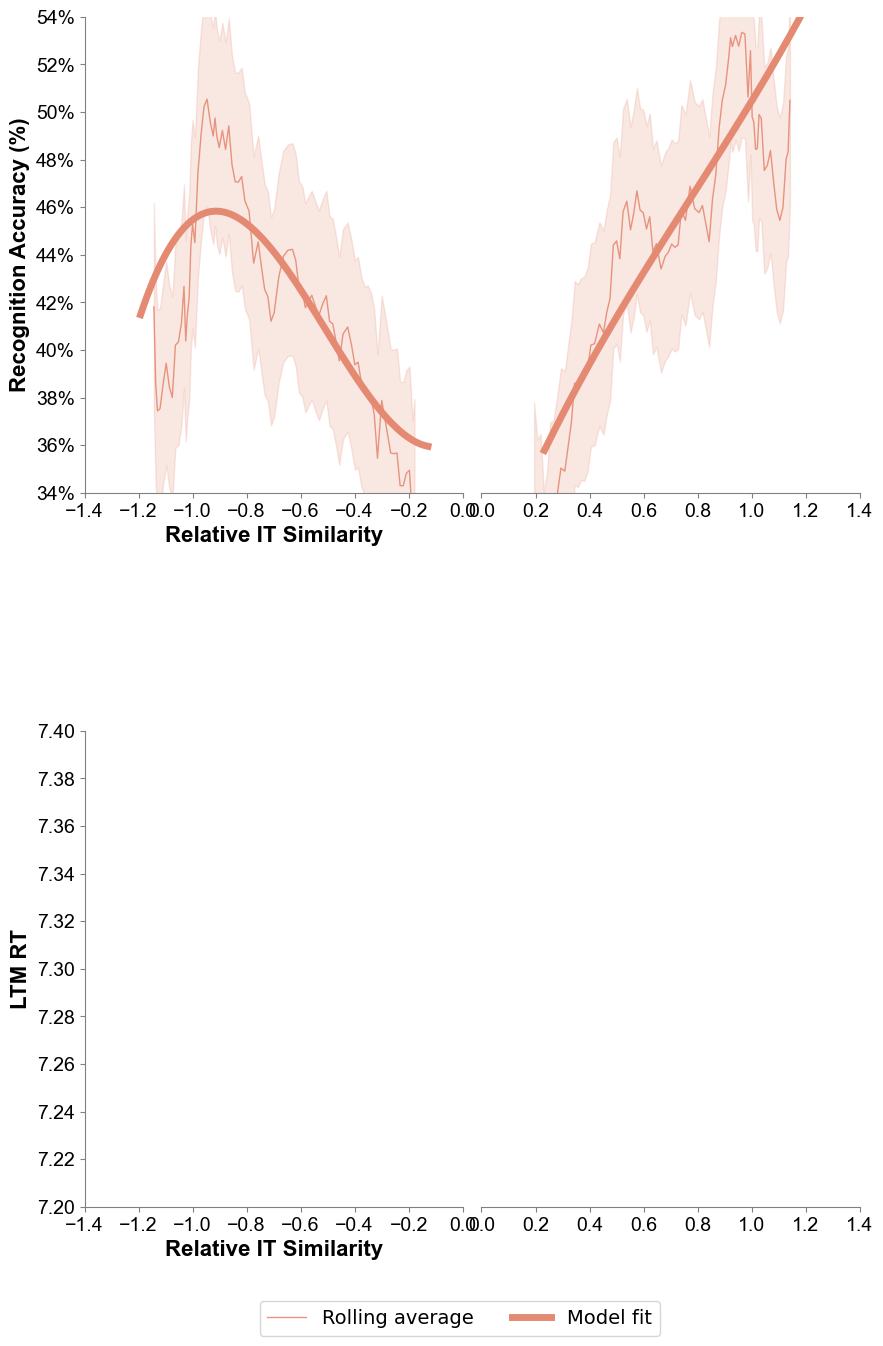

In [110]:


# Create a 2x2 grid with y-axes shared by row and reduced width
fig, axes = plt.subplots(2, 2, figsize=(10, 14), sharey='row')  # Changed from 3x2 to 2x2, height from 20 to 14
fig.subplots_adjust(hspace=0.5, wspace=0.05, top=0.95)  # Reduced wspace from 0.15 to 0.05

# Keep track of all handles and labels for a shared legend
all_handles = []
all_labels = []

# Iterate through rows (now only 2 rows instead of 3)
for i, config in enumerate(plot_configs):
    row = i
    ax_left = axes[row, 0]
    ax_right = axes[row, 1]
    
    combined_sliding_window_and_model_fit_split_col_subplot(
        config['df'],
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config.get('item_col'),  # Use get to handle missing keys
        split_col=config['split_col'],
        split_value=config['split_value'],
        window_percent=0.2,
        step_percent=0.01,
        ax_left=ax_left,  # Pass the axes
        ax_right=ax_right,  # Pass the axes
        y_limits=config.get('y_limits', None),
        x_limits_left=config.get('x_limits_left', None),   # New parameter
        x_limits_right=config.get('x_limits_right', None), # New parameter
        x_tick_step=config.get('x_tick_step', None),       # X-tick step parameter
        share_y=True,
        
        # Model fit orders
        left_model_order=config.get('left_model_order', 1),
        right_model_order=config.get('right_model_order', 2),
        
        # Robust and styling options
        trim_percentile=config.get('trim_percentile', 0),
        y_as_percentage=config.get('y_as_percentage', False),  # UNCOMMENTED THIS LINE
        y_percentage_step=config.get('y_percentage_step', 2),
        y_tick_step=config.get('y_tick_step'),
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 16),    # Increased default
        tick_font_size=config.get('tick_font_size', 14),      # Increased default
        title_font_size=18,                                   # Increased from 16
        legend_font_size=14,                                  # Increased from 12
        show_titles=False                                     # No titles
    )
    
    # Collect handles and labels from both subplots
    for ax in [ax_left, ax_right]:
        handles, labels = ax.get_legend_handles_labels()
        for handle, label in zip(handles, labels):
            # Clean up label to remove (rolling) or (model) suffix
            if "(" in label:
                base_label = label.split("(")[0].strip()
            else:
                base_label = label
            if base_label not in all_labels:
                all_handles.append(handle)
                all_labels.append(base_label)

# Create one shared legend for the entire figure
if all_handles:
    fig.legend(all_handles, all_labels, loc='center', bbox_to_anchor=(0.5, 0.02), 
               ncol=len(all_labels), frameon=True, fontsize=14)  # Increased legend font size

# Manual layout adjustment (no tight_layout needed since we're using sharey and manual spacing)
plt.subplots_adjust(bottom=0.1, hspace=0.5, wspace=0.05, top=0.95)  # Reduced wspace from 0.15 to 0.05
plt.show()

In [112]:
# Keep backward compatibility
create_three_panel_visualization = create_multi_panel_visualization

def combined_sliding_window_and_model_fit_split_col_subplot(df, x_col="Tested - Untested V2 Distractor Similarity", 
                                               y_col='Accuracy', item_col=None,
                                               split_col='v2_pos_neg', split_value=0,
                                               window_percent=0.2, step_percent=0.02,
                                               palette=None, aspect=0.7, figsize_height=6,
                                               ax_left=None, ax_right=None,
                                               y_limits=None, share_y=True,
                                               
                                               # Calculate figure width based on height and aspect ratio
        figsize_width = 2 * figsize_height * aspect  # 2 panels * height * aspect
        
        # Create figure with specified dimensions
        fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(figsize_width, figsize_height), 
                                                 sharey=share_y)
        created_fig = True
    
    # Set background colors
    if created_fig:
        fig.patch.set_facecolor('white')
    ax_left.set_facecolor('white')
    ax_right.set_facecolor('white')
    
    # Create a consistent item to color mapping using ALL data
    item_color_dict = {}
    if item_col is not None and item_col in df.columns:
        all_items = df[item_col].unique()
        for i, item in enumerate(all_items):
            item_lower = str(item).lower()
            if item_lower in color_map:
                item_color_dict[item] = color_map[item_lower]
            elif 'prioritized' in item_lower:
                item_color_dict[item] = color_map['prioritized']
            elif 'deprioritized' in item_lower:
                item_color_dict[item] = color_map['deprioritized']
            else:
                item_color_dict[item] = palette[i % len(palette)]
    
    # Function to process data for each side - simplified version
    def process_side(df_side, ax, side_name, model_order):
        df_side_copy = df_side.copy().sort_values(by=x_col).reset_index(drop=True)
        total_points = len(df_side_copy)
        
        window_points = max(int(total_points * window_percent), 3)
        step_points = max(int(total_points * step_percent), 1)
        color = palette[0]
        
        # Plot rolling average
        if total_points >= window_points:
            x_vals, y_vals, y_errs = [], [], []
            for j in range(0, total_points - window_points + 1, step_points):
                window = df_side_copy.iloc[j:j+window_points]
                mean_x = window[x_col].mean()
                mean_y = window[y_col].mean()
                std_y = window[y_col].std()
                sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                x_vals.append(mean_x)
                y_vals.append(mean_y)
                y_errs.append(sem_y)
            
            x_vals = np.array(x_vals)
            y_vals = np.array(y_vals)
            y_errs = np.array(y_errs)
            
            if len(x_vals) > 0:
                ax.plot(x_vals, y_vals, color=color, linewidth=rolling_line_width, 
                       alpha=rolling_alpha, label='Rolling average')
                ax.fill_between(x_vals, y_vals - 1.96 * y_errs, y_vals + 1.96 * y_errs,
                               color=color, alpha=confidence_alpha)
        
        # Plot model fit
        if trim_percentile > 0:
            lower_p = np.percentile(df_side_copy[x_col], trim_percentile)
            upper_p = np.percentile(df_side_copy[x_col], 100 - trim_percentile)
            df_side_trimmed = df_side_copy[(df_side_copy[x_col] >= lower_p) & (df_side_copy[x_col] <= upper_p)]
        else:
            df_side_trimmed = df_side_copy
        
        if len(df_side_trimmed) >= 5:
            x_range = np.linspace(df_side_trimmed[x_col].min(), df_side_trimmed[x_col].max(), 100)
            model = np.poly1d(np.polyfit(df_side_trimmed[x_col], df_side_trimmed[y_col], model_order))
            ax.plot(x_range, model(x_range), color=color, linestyle='-', 
                    linewidth=model_line_width, label='Model fit')
    
    # Process both sides
    process_side(df_left, ax_left, "Negative", left_model_order)
    process_side(df_right, ax_right, "Positive", right_model_order)
    
    # Set titles and labels
    if show_titles:
        ax_left.set_title("Negative", fontsize=title_font_size, 
                         color=title_font_color, fontweight=title_font_weight, 
                         fontfamily=font_family, pad=20)
        ax_right.set_title("Positive", fontsize=title_font_size, 
                          color=title_font_color, fontweight=title_font_weight, 
                          fontfamily=font_family, pad=20)

    # Set axis labels
    if x_col in ["Tested - Untested IT Distractor Similarity"]:
        ax_left.set_xlabel("Relative IT Similarity", fontweight=label_font_weight, 
                          fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
    elif x_col in ["Tested - Untested V2 Distractor Similarity"]:
        ax_left.set_xlabel("Relative V2 Similarity", fontweight=label_font_weight, 
                          fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
    else:
        ax_left.set_xlabel(x_col, fontweight=label_font_weight, fontsize=label_font_size, 
                          color=label_font_color, fontfamily=font_family)
    
    # Set y-axis labels
    if y_col.lower() in ['accuracy', 'ltm accuracy']:
        if y_as_percentage:
            ax_left.set_ylabel("Recognition Accuracy (%)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
            ax_left.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
            if y_tick_step is None:
                y_tick_step = y_percentage_step / 100.0
        else:
            ax_left.set_ylabel("Recognition Accuracy (% Correct)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
    else:
        ax_left.set_ylabel(y_col, fontweight=label_font_weight, fontsize=label_font_size, 
                         color=label_font_color, fontfamily=font_family)
    
    # Set tick steps and limits
    if x_tick_step is not None:
        ax_left.xaxis.set_major_locator(MultipleLocator(x_tick_step))
        ax_right.xaxis.set_major_locator(MultipleLocator(x_tick_step))
    
    if y_tick_step is not None:
        ax_left.yaxis.set_major_locator(MultipleLocator(y_tick_step))
        if not share_y:
            ax_right.yaxis.set_major_locator(MultipleLocator(y_tick_step))
    
    # Set axis limits
    if x_limits_left is not None:
        ax_left.set_xlim(x_limits_left)
    elif x_limits is not None:
        ax_left.set_xlim(x_limits[0], 0)
    
    if x_limits_right is not None:
        ax_right.set_xlim(x_limits_right)
    elif x_limits is not None:
        ax_right.set_xlim(0, x_limits[1])
    
    # Style axes
    spine_color = 'grey'
    for ax in [ax_left, ax_right]:
        ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
        ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
        for label in ax.get_xticklabels():
            label.set_fontfamily(font_family)
        for label in ax.get_yticklabels():
            label.set_fontfamily(font_family)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_color(spine_color)
        ax.spines['left'].set_color(spine_color)
        ax.grid(False)
    
    if share_y:
        ax_right.yaxis.set_visible(False)
        ax_right.spines['left'].set_visible(False)
    
    # Set y-limits
    if y_limits is not None:
        ax_left.set_ylim(y_limits)
        ax_right.set_ylim(y_limits)
    elif y_col.lower() in ['accuracy', 'acc', 'correct', 'resp_correct', 'ltm accuracy']:
        ax_left.set_ylim(0.6, 0.8)
        ax_right.set_ylim(0.6, 0.8)
    
    # Add legend
    if created_fig:
        handles, labels = ax_left.get_legend_handles_labels()
        handles2, labels2 = ax_right.get_legend_handles_labels()
        all_handles = handles + handles2
        all_labels = labels + labels2
        by_label = dict(zip(all_labels, all_handles))
        if by_label:
            legend = fig.legend(by_label.values(), by_label.keys(), 
                              loc='lower center', ncol=len(by_label), bbox_to_anchor=(0.5, -0.05),
                              fontsize=legend_font_size)
            for text in legend.get_texts():
                text.set_fontfamily(font_family)
                text.set_color(legend_font_color)
        plt.subplots_adjust(bottom=0.15)
    
    return fig Model fit order parameters
                                               left_model_order=2, right_model_order=2,
                                               
                                               # Robust regression options
                                               trim_percentile=0,  # Trim extreme percentiles (0 = no trim)
                                               
                                               # Font and color parameters
                                               font_family='Arial', 
                                               title_font_size=18, title_font_color='black', title_font_weight='bold',
                                               label_font_size=16, label_font_color='black', label_font_weight='bold',
                                               tick_font_size=14, tick_font_color='black',
                                               legend_font_size=14, legend_font_color='black',
                                               
                                               # Axis formatting parameters
                                               y_as_percentage=False, y_percentage_step=2, 
                                               x_tick_step=None, y_tick_step=None,
                                               x_limits=None,
                                               x_limits_left=None, x_limits_right=None,
                                               
                                               # Visual parameters
                                               rolling_line_width=1, model_line_width=5, 
                                               confidence_alpha=0.2, rolling_alpha=0.9,
                                               
                                               # Title control
                                               show_titles=True):
    """
    Enhanced sliding window and model fit with customizable fonts, colors, and robust options.
    """
   
    # Define colors
    grey = '#BFBFBF'
    blue = '#6cbcef'
    teal = '#49a791'
    purple = '#a271b1'
    salmon = '#e58a72'
    gold = '#dbad40'
    green = '#95c355'
    
    # Auto-select color based on x column if no palette provided
    if palette is None:
        if "IT Distractor" in x_col:
            palette = [salmon]  # Salmon for IT
        elif "V2 Distractor" in x_col:
            palette = [gold]  # Gold for V2
        else:
            palette = [purple]  # default
    
    # Color map for specific item types - adapts to data type
    if "IT Distractor" in x_col:
        primary_color = salmon
    elif "V2 Distractor" in x_col:
        primary_color = gold  
    else:
        primary_color = purple
        
    color_map = {
        'prioritized': primary_color,
        'deprioritized': grey
    }

    # Split the data
    df_left = df[df[x_col] <= split_value].copy()
    df_right = df[df[x_col] > split_value].copy()
    
    # If axes are provided, use them; otherwise create new figure
    if ax_left is not None and ax_right is not None:
        # Use provided axes
        fig = ax_left.get_figure()
        created_fig = False
    else:
        #import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter, MultipleLocator

def remove_leading_zero_formatter(x, pos):
    if x == 0:
        return '0'
    elif x > 0:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('0.'):
            return formatted[1:]
        return formatted
    else:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('-0.'):
            return '-' + formatted[2:]
        return formatted

def create_continuous_rolling_plot(df, x_col, y_col, item_col=None, 
                                 window_percent=0.1, step_percent=0.02,
                                 ax=None, 
                                 y_limits=None, x_limits=None,
                                 x_tick_step=None, y_tick_step=None, x_ticks=None,
                                 y_as_percentage=False, y_percentage_step=2,
                                 font_family='Arial',
                                 title_font_size=18, title_font_color='black', title_font_weight='bold',
                                 label_font_size=16, label_font_color='black', label_font_weight='bold',
                                 tick_font_size=14, tick_font_color='black',
                                 line_width=3, confidence_alpha=0.2,
                                 show_title=True):
    
    if "IT Distractor Similarity" in x_col:
        palette = ['#e58a72']  # Salmon for IT
    elif "V2 Distractor Similarity" in x_col:
        palette = ['#dbad40']  # Gold for V2
    else:
        palette = ['#49a791']
    
    # Create rolling plot directly instead of calling undefined function
    df_sorted = df.copy().sort_values(by=x_col).reset_index(drop=True)
    total_points = len(df_sorted)
    
    window_points = max(int(total_points * window_percent), 3)
    step_points = max(int(total_points * step_percent), 1)
    color = palette[0]
    
    if total_points >= window_points:
        x_vals, y_vals, y_errs = [], [], []
        for j in range(0, total_points - window_points + 1, step_points):
            window = df_sorted.iloc[j:j+window_points]
            mean_x = window[x_col].mean()
            mean_y = window[y_col].mean()
            std_y = window[y_col].std()
            sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
            x_vals.append(mean_x)
            y_vals.append(mean_y)
            y_errs.append(sem_y)
        
        x_vals = np.array(x_vals)
        y_vals = np.array(y_vals)
        y_errs = np.array(y_errs)
        
        if len(x_vals) > 0:
            ax.plot(x_vals, y_vals, color=color, linewidth=line_width, alpha=0.9)
            ax.fill_between(x_vals, 
                           y_vals - 1.96 * y_errs,
                           y_vals + 1.96 * y_errs,
                           color=color, alpha=confidence_alpha)
    
    # Apply formatting
    if y_as_percentage:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
    
    if x_tick_step is not None:
        ax.xaxis.set_major_locator(MultipleLocator(x_tick_step))
    if y_tick_step is not None:
        ax.yaxis.set_major_locator(MultipleLocator(y_tick_step))
    
    if x_limits is not None:
        ax.set_xlim(x_limits)
    if y_limits is not None:
        ax.set_ylim(y_limits)
    
    ax.axvline(x=0, color='grey', linestyle='--', alpha=0.7, linewidth=3)
    
    if show_title:
        ax.set_title("Continuous", fontsize=title_font_size-2, 
                    color=title_font_color, fontweight=title_font_weight, 
                    fontfamily=font_family, pad=15)
    
    ax.set_xlabel('')
    ax.tick_params(axis='x', bottom=False, labelbottom=False)
    ax.spines['bottom'].set_visible(False)
    
    return ax


def create_single_side_plot(df, x_col, y_col, item_col=None, 
                           split_col='v2_pos_neg', split_value=0, side='left',
                           window_percent=0.2, step_percent=0.02,
                           ax=None, palette=None,
                           y_limits=None, x_limits=None,
                           x_tick_step=None, y_tick_step=None,
                           model_order=2, trim_percentile=0,
                           y_as_percentage=False, y_percentage_step=2,
                           x_buffer_percent=0.05,  # NEW PARAMETER for x-axis buffer from y-axis
                           font_family='Arial',
                           title_font_size=18, title_font_color='black', title_font_weight='bold',
                           label_font_size=16, label_font_color='black', label_font_weight='bold',
                           tick_font_size=14, tick_font_color='black',
                           rolling_line_width=1, model_line_width=5,
                           confidence_alpha=0.2, rolling_alpha=0.9,
                           show_title=True, show_ylabel=True, show_xlabel=True,
                           grey_out_model=False):
    
    grey = '#BFBFBF'
    blue = '#6cbcef'
    teal = '#49a791'
    purple = '#a271b1'
    salmon = '#e58a72'
    gold = '#dbad40'
    green = '#95c355'
    
    if palette is None:
        if "IT Distractor Similarity" in x_col:
            default_colors = [salmon, grey]  # Salmon for IT
        elif "V2 Distractor Similarity" in x_col:
            default_colors = [gold, grey]  # Gold for V2
        else:
            default_colors = [teal, grey]
    else:
        default_colors = palette
    
    color_map = {
        'prioritized': default_colors[0],    
        'deprioritized': default_colors[1] if len(default_colors) > 1 else grey,  
    }
    
    if side == 'left':
        df_side = df[df[x_col] <= split_value].copy()
        title_text = f"{x_col} ≤ {split_value}"
    else:
        df_side = df[df[x_col] > split_value].copy()
        title_text = f"{x_col} > {split_value}"
    
    ax.set_facecolor('white')
    
    item_color_dict = {}
    if item_col is not None and item_col in df.columns:
        all_items = df[item_col].unique()
        for i, item in enumerate(all_items):
            item_lower = str(item).lower()
            if item_lower in color_map:
                item_color_dict[item] = color_map[item_lower]
            elif 'prioritized' in item_lower:
                item_color_dict[item] = color_map['prioritized']
            elif 'deprioritized' in item_lower:
                item_color_dict[item] = color_map['deprioritized']
            else:
                item_color_dict[item] = default_colors[i % len(default_colors)]
    
    if item_col is not None and item_col in df.columns:
        items = df_side[item_col].unique()
        
        for i, item in enumerate(items):
            df_item = df_side[df_side[item_col] == item].copy()
            df_item = df_item.sort_values(by=x_col).reset_index(drop=True)
            total_points = len(df_item)
            
            window_points = max(int(total_points * window_percent), 3)
            step_points = max(int(total_points * step_percent), 1)
            color = item_color_dict.get(item, default_colors[i % len(default_colors)])
            
            if total_points >= window_points:
                print(f"{side} side - {item}, Total points: {total_points}, "
                      f"Window size: {window_points}, Step size: {step_points}")
                
                x_vals, y_vals, y_errs = [], [], []
                for j in range(0, total_points - window_points + 1, step_points):
                    window = df_item.iloc[j:j+window_points]
                    mean_x = window[x_col].mean()
                    mean_y = window[y_col].mean()
                    std_y = window[y_col].std()
                    sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                    x_vals.append(mean_x)
                    y_vals.append(mean_y)
                    y_errs.append(sem_y)
                
                x_vals = np.array(x_vals)
                y_vals = np.array(y_vals)
                y_errs = np.array(y_errs)
                
                if len(x_vals) > 0:
                    ax.plot(x_vals, y_vals, color=color, linewidth=rolling_line_width, 
                           alpha=rolling_alpha, label=f'{item} (rolling)')
                    ax.fill_between(x_vals, 
                                   y_vals - 1.96 * y_errs,
                                   y_vals + 1.96 * y_errs,
                                   color=color, alpha=confidence_alpha)
        
        for i, item in enumerate(items):
            df_item = df_side[df_side[item_col] == item].copy()
            
            if trim_percentile > 0:
                lower_p = np.percentile(df_item[x_col], trim_percentile)
                upper_p = np.percentile(df_item[x_col], 100 - trim_percentile)
                df_item_trimmed = df_item[(df_item[x_col] >= lower_p) & (df_item[x_col] <= upper_p)]
            else:
                df_item_trimmed = df_item
                
            total_points = len(df_item_trimmed)
            color = item_color_dict.get(item, default_colors[i % len(default_colors)])
            
            # MODIFIED: Use grey color if grey_out_model is True
            model_color = '#BFBFBF' if grey_out_model else color
            
            if total_points >= 5:
                total_points_full = len(df_item)
                window_points_full = max(int(total_points_full * window_percent), 3)
                
                df_item_sorted = df_item.sort_values(by=x_col)
                rolling_min_x = df_item_sorted.iloc[window_points_full//2][x_col]
                rolling_max_x = df_item_sorted.iloc[-(window_points_full//2 + 1)][x_col]
                
                points_below_rolling = len(df_item_trimmed[df_item_trimmed[x_col] < rolling_min_x])
                points_above_rolling = len(df_item_trimmed[df_item_trimmed[x_col] > rolling_max_x])
                
                model_min_x = max(df_item_trimmed[x_col].min(), rolling_min_x)
                model_max_x = min(df_item_trimmed[x_col].max(), rolling_max_x)
                
                points_in_model = len(df_item_trimmed[
                    (df_item_trimmed[x_col] >= model_min_x) & 
                    (df_item_trimmed[x_col] <= model_max_x)
                ])
                
                points_excluded_by_trim = len(df_item) - len(df_item_trimmed)
                
                print(f"  📊 {side} side - {item} Model Fit Exclusions:")
                print(f"     Total points: {len(df_item)}")
                if trim_percentile > 0:
                    print(f"     Excluded by trimming ({trim_percentile}%): {points_excluded_by_trim}")
                    print(f"     Remaining after trim: {len(df_item_trimmed)}")
                else:
                    print(f"     No trimming applied")
                print(f"     Excluded by rolling constraint - Left edge: {points_below_rolling}")
                print(f"     Excluded by rolling constraint - Right edge: {points_above_rolling}")
                print(f"     Points used in model fit: {points_in_model}")
                print(f"     Total excluded: {len(df_item) - points_in_model}")
                
                if model_max_x > model_min_x:
                    x_range = np.linspace(model_min_x, model_max_x, 100)
                    model = np.poly1d(np.polyfit(df_item_trimmed[x_col], df_item_trimmed[y_col], model_order))
                    ax.plot(x_range, model(x_range), color=model_color, linestyle='-', 
                            linewidth=model_line_width, label=f'{item} (model)')
    else:
        df_side_copy = df_side.copy().sort_values(by=x_col).reset_index(drop=True)
        total_points = len(df_side_copy)
        
        window_points = max(int(total_points * window_percent), 3)
        step_points = max(int(total_points * step_percent), 1)
        color = default_colors[0]
        
        if total_points >= window_points:
            print(f"{side} side - All Data, Total points: {total_points}, "
                  f"Window size: {window_points}, Step size: {step_points}")
            
            x_vals, y_vals, y_errs = [], [], []
            for j in range(0, total_points - window_points + 1, step_points):
                window = df_side_copy.iloc[j:j+window_points]
                mean_x = window[x_col].mean()
                mean_y = window[y_col].mean()
                std_y = window[y_col].std()
                sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                x_vals.append(mean_x)
                y_vals.append(mean_y)
                y_errs.append(sem_y)
            
            x_vals = np.array(x_vals)
            y_vals = np.array(y_vals)
            y_errs = np.array(y_errs)
            
            if len(x_vals) > 0:
                ax.plot(x_vals, y_vals, color=color, linewidth=rolling_line_width, 
                       alpha=rolling_alpha, label='Rolling average')
                ax.fill_between(x_vals, 
                               y_vals - 1.96 * y_errs,
                               y_vals + 1.96 * y_errs,
                               color=color, alpha=confidence_alpha)
        
        if trim_percentile > 0:
            lower_p = np.percentile(df_side_copy[x_col], trim_percentile)
            upper_p = np.percentile(df_side_copy[x_col], 100 - trim_percentile)
            df_side_trimmed = df_side_copy[(df_side_copy[x_col] >= lower_p) & (df_side_copy[x_col] <= upper_p)]
        else:
            df_side_trimmed = df_side_copy
            
        total_points_trimmed = len(df_side_trimmed)
        
        # MODIFIED: Use grey color if grey_out_model is True
        model_color = '#BFBFBF' if grey_out_model else color
        
        if total_points_trimmed >= 5:
            window_points_full = max(int(total_points * window_percent), 3)
            
            df_side_sorted = df_side_copy.sort_values(by=x_col)
            rolling_min_x = df_side_sorted.iloc[window_points_full//2][x_col]
            rolling_max_x = df_side_sorted.iloc[-(window_points_full//2 + 1)][x_col]
            
            points_below_rolling = len(df_side_trimmed[df_side_trimmed[x_col] < rolling_min_x])
            points_above_rolling = len(df_side_trimmed[df_side_trimmed[x_col] > rolling_max_x])
            
            model_min_x = max(df_side_trimmed[x_col].min(), rolling_min_x)
            model_max_x = min(df_side_trimmed[x_col].max(), rolling_max_x)
            
            points_in_model = len(df_side_trimmed[
                (df_side_trimmed[x_col] >= model_min_x) & 
                (df_side_trimmed[x_col] <= model_max_x)
            ])
            
            points_excluded_by_trim = len(df_side_copy) - len(df_side_trimmed)
            
            print(f"  📊 {side} side - All Data Model Fit Exclusions:")
            print(f"     Total points: {len(df_side_copy)}")
            if trim_percentile > 0:
                print(f"     Excluded by trimming ({trim_percentile}%): {points_excluded_by_trim}")
                print(f"     Remaining after trim: {len(df_side_trimmed)}")
            else:
                print(f"     No trimming applied")
            print(f"     Excluded by rolling constraint - Left edge: {points_below_rolling}")
            print(f"     Excluded by rolling constraint - Right edge: {points_above_rolling}")
            print(f"     Points used in model fit: {points_in_model}")
            print(f"     Total excluded: {len(df_side_copy) - points_in_model}")
            
            if model_max_x > model_min_x:
                x_range = np.linspace(model_min_x, model_max_x, 100)
                model = np.poly1d(np.polyfit(df_side_trimmed[x_col], df_side_trimmed[y_col], model_order))
                ax.plot(x_range, model(x_range), color=model_color, linestyle='-', 
                        linewidth=model_line_width, label='Model fit')
    
    if show_title:
        if side == 'left':
            ax.set_title("Negative", fontsize=title_font_size, 
                        color=title_font_color, fontweight=title_font_weight, 
                        fontfamily=font_family, pad=20)
        else:
            ax.set_title("Positive", fontsize=title_font_size, 
                        color=title_font_color, fontweight=title_font_weight, 
                        fontfamily=font_family, pad=20)
    
    if show_xlabel:
        if x_col in ["Tested - Untested IT Distractor Similarity"]:
            ax.set_xlabel("Relative IT Similarity", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif x_col in ["Tested - Untested V2 Distractor Similarity"]:
            ax.set_xlabel("Relative V2 Similarity", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        else:
            ax.set_xlabel(x_col, fontweight=label_font_weight, fontsize=label_font_size, 
                         color=label_font_color, fontfamily=font_family, labelpad=15)
    else:
        ax.set_xlabel('')
    
    if show_ylabel:
        if y_col.lower() in ['accuracy']:
            if y_as_percentage:
                ax.set_ylabel("Choice Accuracy (% Correct)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
                ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
                if y_tick_step is None:
                    y_tick_step = y_percentage_step / 100.0
            else:
                ax.set_ylabel("Choice Accuracy (% Correct)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif y_col.lower() in ['wm rt']:
            ax.set_ylabel("WM RT", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif y_col.lower() in ['error category accuracy']:
            if y_as_percentage:
                ax.set_ylabel("Within Category Errors (%)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
                ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
                if y_tick_step is None:
                    y_tick_step = y_percentage_step / 100.0
            else:
                ax.set_ylabel("Within Category Errors", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        else:
            ax.set_ylabel(y_col, fontweight=label_font_weight, fontsize=label_font_size, 
                         color=label_font_color, fontfamily=font_family, labelpad=15)
    
    if x_tick_step is not None:
        ax.xaxis.set_major_locator(MultipleLocator(x_tick_step))
    if y_tick_step is not None:
        ax.yaxis.set_major_locator(MultipleLocator(y_tick_step))
    
    # Handle x-limits with buffer space from y-axis
    if x_limits is not None:
        if side == 'left':
            # For left side, extend further left to create buffer from y-axis
            x_min, x_max = x_limits[0], split_value
            x_range = abs(x_max - x_min)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(x_min - buffer, x_max)
        else:
            # For right side, extend leftward (toward 0) to create buffer from y-axis  
            x_min, x_max = split_value, x_limits[1]
            x_range = abs(x_max - x_min)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(x_min - buffer, x_max)
    else:
        # If no x_limits provided, get data range and add buffer
        if side == 'left':
            data_x_min = df_side[x_col].min()
            x_range = abs(split_value - data_x_min)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(data_x_min - buffer, split_value)
        else:
            data_x_max = df_side[x_col].max()
            x_range = abs(data_x_max - split_value)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(split_value - buffer, data_x_max)
    
    # Handle y-limits (keeping existing logic but simplifying)
    if y_limits is not None:
        ax.set_ylim(y_limits)
    elif y_col.lower() in ['accuracy', 'acc', 'correct', 'resp_correct']:
        ax.set_ylim(0.6, 0.8)
    
    ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    spine_color = '#B8B8B8'
    ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
    ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
    
    for label in ax.get_xticklabels():
        label.set_fontfamily(font_family)
    for label in ax.get_yticklabels():
        label.set_fontfamily(font_family)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color(spine_color)
    ax.spines['left'].set_color(spine_color)
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.grid(False)
    
    return ax

# Plot configurations
# NOTE: Make sure your dataframe 'df' is defined before using these configs

plot_configs_it = [
    {
        'df': df,
        'x_col': 'LTM - NonLTM IT Distractor Similarity',
        'y_col': "LTM Accuracy",
        # 'item_col': "Tested Item",
        'split_col': "IT_pos_neg",
        'split_value': 0,
        'y_limits': (0.72, 0.84), # Custom y-axis limits
        'x_limits': (-1.4, 1.4),  # Combined x limits
        'x_tick_step': 0.2,           # X-axis ticks every 0.2
        'left_model_order': 3,         # 3rd order polynomial for left side
        'right_model_order': 3,        # 3rd order polynomial for right side
        'trim_percentile': 0,          # Remove extreme 0% from each tail
        'y_as_percentage': True,       # Format as percentages
        'y_percentage_step': 2,        # Every 2%
        'font_family': 'Arial',
        'label_font_size': 16,         # Increased from 14
        'tick_font_size': 14           # Increased from 12
    }
]

plot_configs_v2 = [
    {
        'df': df,
        'x_col': 'Tested - Untested V2 Distractor Similarity',
        'y_col': "LTM Accuracy",
        # 'item_col': "Tested Item",
        'split_col': "V2_pos_neg",
        'split_value': 0,
        'y_limits': (0.34, 0.54), # Custom y-axis limits
        'x_limits': (-0.2, 0.2),   # Combined x limits
        'x_tick_step': 0.04,           # X-axis ticks every 0.04
        'left_model_order': 3,         # 3rd order polynomial for left side
        'right_model_order': 3,        # 3rd order polynomial for right side
        'trim_percentile': 0,          # Remove extreme 0% from each tail
        'y_as_percentage': True,       # Format as percentages
        'y_percentage_step': 2,        # Every 2%
        'font_family': 'Arial',
        'label_font_size': 16,         # Increased from 14
        'tick_font_size': 14           # Increased from 12
    }
]

def create_multi_panel_visualization(plot_configs, middle_width=0.35, middle_height_shift=0.0, 
                                   middle_size_scale=0.7, adjustable_gap=0.01, 
                                   grey_out_models=None, x_buffer_percent=0.05):
    """
    Create multi-panel visualization with option to grey out specific model fits.
    
    Parameters:
    -----------
    plot_configs : list
        List of configuration dictionaries, one for each row
    grey_out_models : dict, optional
        Dictionary specifying which model fits to grey out.
        Format: {row_index: {'left': bool, 'right': bool}}
        Example: {0: {'right': True}} would grey out the model fit in row 0, right panel
    x_buffer_percent : float, optional
        Percentage of x-range to add as buffer space between y-axis and plot data (default: 0.05 = 5%)
    """
    
    from matplotlib.gridspec import GridSpec
    
    # Make figure height scale with number of rows
    num_rows = len(plot_configs)
    fig_height = 22 * (num_rows / 3)  # Scale based on original 3-row design
    fig = plt.figure(figsize=(18, fig_height))
    
    # Keep plot sizes FIXED regardless of gap size
    original_gap_width = 0.01
    original_remaining_width = 1.0 - middle_width - 2*original_gap_width
    fixed_side_width = original_remaining_width / 2 * 0.6
    fixed_middle_width = middle_width
    
    current_gap_width = adjustable_gap
    
    total_plot_width = 2 * fixed_side_width + fixed_middle_width + 2 * current_gap_width
    remaining_for_margins = 1.0 - total_plot_width
    outer_margin = remaining_for_margins / 2
    
    if outer_margin < 0.001:
        outer_margin = 0.001
    
    # Create flexible height ratios for any number of rows
    height_ratios = [1] * num_rows
    
    gs = GridSpec(num_rows, 7, figure=fig, 
                  width_ratios=[outer_margin, fixed_side_width, current_gap_width, fixed_middle_width, current_gap_width, fixed_side_width, outer_margin],  
                  height_ratios=height_ratios,   
                  hspace=0.25, wspace=0.01,
                  top=0.95, bottom=0.1, left=0.05, right=0.95)
    axes = []
    for row in range(num_rows):
        ax_left = fig.add_subplot(gs[row, 1])
        ax_middle = fig.add_subplot(gs[row, 3])
        ax_right = fig.add_subplot(gs[row, 5])
        axes.append([ax_left, ax_middle, ax_right])

    all_handles = []
    all_labels = []
    
    # Initialize grey_out_models if not provided
    if grey_out_models is None:
        grey_out_models = {}
    
    for row, config in enumerate(plot_configs):
        x_col = config['x_col']
        if "IT Distractor Similarity" in x_col:
            frame_color = '#e58a72'  # Salmon for IT
        elif "V2 Distractor Similarity" in x_col:
            frame_color = '#dbad40'  # Gold for V2
        else:
            frame_color = '#49a791'
        
        y_limits = config.get('y_limits')
        
        # Check if left side should be greyed out
        grey_left = grey_out_models.get(row, {}).get('left', False)
        grey_right = grey_out_models.get(row, {}).get('right', False)
        
        create_single_side_plot(
            config['df'],
            x_col=config['x_col'],
            y_col=config['y_col'],
            item_col=config.get('item_col'),
            split_col=config.get('split_col', 'v2_pos_neg'),  # Use config's split_col
            split_value=config.get('split_value', 0),
            side='left',
            ax=axes[row][0],
            y_limits=y_limits,
            x_limits=config.get('x_limits'),
            x_tick_step=config.get('x_tick_step'),
            y_tick_step=config.get('y_tick_step'),
            model_order=config.get('left_model_order', 2),
            trim_percentile=config.get('trim_percentile', 0),
            window_percent=config.get('window_percent', 0.2),
            step_percent=config.get('step_percent', 0.02),
            y_as_percentage=config.get('y_as_percentage', False),
            y_percentage_step=config.get('y_percentage_step', 2),
            x_buffer_percent=x_buffer_percent,  # UPDATED PARAMETER
            font_family=config.get('font_family', 'Arial'),
            label_font_size=config.get('label_font_size', 16),
            tick_font_size=config.get('tick_font_size', 14),
            show_title=False,
            show_ylabel=True,
            show_xlabel=False,
            grey_out_model=grey_left  # Pass the grey_out parameter
        )
        
        axes[row][0].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
        
        create_continuous_rolling_plot(
            config['df'],
            x_col=config['x_col'],
            y_col=config['y_col'],
            item_col=config.get('item_col'),
            ax=axes[row][1],
            y_limits=y_limits,
            x_limits=config.get('x_limits'),
            x_tick_step=config.get('x_tick_step'),
            y_tick_step=config.get('y_tick_step'),
            x_ticks=config.get('x_ticks'),
            y_as_percentage=config.get('y_as_percentage', False),
            y_percentage_step=config.get('y_percentage_step', 2),
            font_family=config.get('font_family', 'Arial'),
            label_font_size=config.get('label_font_size', 14),
            tick_font_size=config.get('tick_font_size', 12),
            window_percent=0.1,
            step_percent = 0.01,
            line_width=2,
            show_title=False
        )
        
        axes[row][1].set_xlabel('')
        axes[row][1].tick_params(axis='x', bottom=False, labelbottom=False)
        axes[row][1].spines['bottom'].set_visible(False)
        
        for spine_name, spine in axes[row][1].spines.items():
            spine.set_visible(True)
            spine.set_linewidth(5)
            spine.set_color(frame_color)
        
        axes[row][1].set_facecolor('#f8f8f8')
        
        pos = axes[row][1].get_position()
        new_width = pos.width * middle_size_scale
        new_height = pos.height * middle_size_scale
        new_x = pos.x0 + (pos.width - new_width) / 2
        new_y = pos.y0 + middle_height_shift
        
        new_pos = [new_x, new_y, new_width, new_height]
        axes[row][1].set_position(new_pos)
        
        create_single_side_plot(
            config['df'],
            x_col=config['x_col'],
            y_col=config['y_col'],
            item_col=config.get('item_col'),
            split_col=config.get('split_col', 'v2_pos_neg'),  # Use config's split_col
            split_value=config.get('split_value', 0),
            side='right',
            ax=axes[row][2],
            y_limits=y_limits,
            x_limits=config.get('x_limits'),
            x_tick_step=config.get('x_tick_step'),
            y_tick_step=config.get('y_tick_step'),
            model_order=config.get('right_model_order', 2),
            trim_percentile=config.get('trim_percentile', 0),
            window_percent=config.get('window_percent', 0.2),
            step_percent=config.get('step_percent', 0.02),
            y_as_percentage=config.get('y_as_percentage', False),
            y_percentage_step=config.get('y_percentage_step', 2),
            x_buffer_percent=x_buffer_percent,  # UPDATED PARAMETER
            font_family=config.get('font_family', 'Arial'),
            label_font_size=config.get('label_font_size', 16),
            tick_font_size=config.get('tick_font_size', 14),
            show_title=False,
            show_ylabel=False,
            show_xlabel=False,
            grey_out_model=grey_right  # Pass the grey_out parameter
        )
        
        axes[row][2].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
        
        axes[row][1].set_ylabel('')
        axes[row][1].tick_params(axis='y', labelleft=False, left=False)
        
        axes[row][2].set_ylabel('')
        axes[row][2].tick_params(axis='y', labelleft=False, left=False)
        axes[row][2].spines['left'].set_visible(False)
        
        for col in range(3):
            handles, labels = axes[row][col].get_legend_handles_labels()
            for handle, label in zip(handles, labels):
                if "(" in label:
                    base_label = label.split("(")[0].strip()
                else:
                    base_label = label
                if base_label not in all_labels:
                    all_handles.append(handle)
                    all_labels.append(base_label)
        
        axes[row][0].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
        axes[row][2].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    if all_handles:
        fig.legend(all_handles, all_labels, loc='lower center', bbox_to_anchor=(0.5, 0.02), 
                   ncol=len(all_labels), frameon=True, fontsize=12)
    
    plt.show()
    return fig

# USAGE EXAMPLES:

# METHOD 1: Three-panel visualization (Left | Continuous | Right)
# For IT distractor similarity (single row) - SALMON color
fig_it = create_multi_panel_visualization(
    plot_configs_it,
    middle_width=0.35,
    middle_height_shift=0.05,
    middle_size_scale=0.5,
    adjustable_gap=-0.03,
    grey_out_models={0: {'right': True}},  # Grey out row 0, right panel
    x_buffer_percent=0.05  # 5% buffer space between y-axis and plot data
)

# For V2 distractor similarity (single row) - GOLD color
fig_v2 = create_multi_panel_visualization(
    plot_configs_v2,
    middle_width=0.35,
    middle_height_shift=0.05,
    middle_size_scale=0.5,
    adjustable_gap=-0.03,
    x_buffer_percent=0.05
)

# # METHOD 2: Two-panel visualization (Left | Right) - simpler approach
# # For V2 distractor similarity using the comprehensive function (GOLD color):
# fig_v2_simple = combined_sliding_window_and_model_fit_split_col_subplot(
#     df=df,
#     x_col='Tested - Untested V2 Distractor Similarity',
#     y_col="LTM Accuracy",
#     split_col="V2_pos_neg",
#     split_value=0,
#     y_limits=(0.34, 0.54),
#     x_limits_left=(-0.2, 0),
#     x_limits_right=(0, 0.2),
#     x_tick_step=0.04,
#     left_model_order=3,
#     right_model_order=3,
#     trim_percentile=0,
#     y_as_percentage=True,
#     y_percentage_step=2,
#     font_family='Arial',
#     label_font_size=16,
#     tick_font_size=14,
#     show_titles=False,  # Clean look without titles
#     figsize_height=6,
#     aspect=0.7
# )

# # For IT distractor similarity using the comprehensive function (SALMON color):
# fig_it_simple = combined_sliding_window_and_model_fit_split_col_subplot(
#     df=df,
#     x_col='LTM - NonLTM IT Distractor Similarity',
#     y_col="LTM Accuracy",
#     split_col="IT_pos_neg",
#     split_value=0,
#     y_limits=(0.72, 0.84),
#     x_limits_left=(-1.4, 0),
#     x_limits_right=(0, 1.4),
#     x_tick_step=0.2,
#     left_model_order=3,
#     right_model_order=3,
#     trim_percentile=0,
#     y_as_percentage=True,
#     y_percentage_step=2,
#     font_family='Arial',
#     label_font_size=16,
#     tick_font_size=14,
#     show_titles=False,
#     figsize_height=6,
#     aspect=0.7
# )

# # Color scheme summary:
# # - IT Distractor Similarity: SALMON (#e58a72)
# # - V2 Distractor Similarity: GOLD (#dbad40)

# Keep backward compatibility
create_three_panel_visualization = create_multi_panel_visualization

SyntaxError: invalid syntax (3544988856.py, line 16)

In [113]:
df['Tested - Untested V2 Distractor Similarity']

0       0.057343
1       0.138244
2       0.013220
3       0.120529
4      -0.032432
          ...   
4371   -0.040833
4372    0.103950
4373    0.042893
4374    0.024894
4375    0.055961
Name: Tested - Untested V2 Distractor Similarity, Length: 4376, dtype: float64

Negative side - All Data, Total points: 2166, Window size: 433, Step size: 43
  📊 Negative side - All Data Model Fit Exclusions:
     Total points: 2166
     No trimming applied
     Excluded by rolling constraint - Left edge: 213
     Excluded by rolling constraint - Right edge: 216
     Points used in model fit: 1737
     Total excluded: 429
Positive side - All Data, Total points: 2210, Window size: 442, Step size: 44
  📊 Positive side - All Data Model Fit Exclusions:
     Total points: 2210
     No trimming applied
     Excluded by rolling constraint - Left edge: 211
     Excluded by rolling constraint - Right edge: 218
     Points used in model fit: 1781
     Total excluded: 429


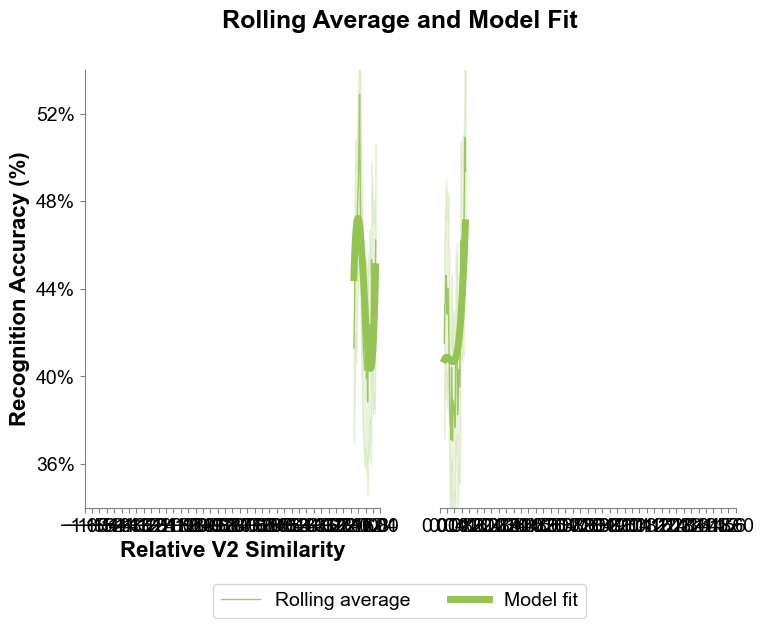

In [114]:
fig_v2_simple = combined_sliding_window_and_model_fit_split_col_subplot(
    df=df,
    x_col='Tested - Untested V2 Distractor Similarity',
    y_col="LTM Accuracy",
    split_col="V2_pos_neg",
    split_value=0,
    y_limits=(0.34, 0.54),
    x_limits_left=(-1.6, 0),
    x_limits_right=(0, 1.6),
    x_tick_step=0.04,
    left_model_order=3,
    right_model_order=3,
    y_as_percentage=True,
    y_percentage_step=4,
    show_titles=False
)

Negative side - All Data, Total points: 2157, Window size: 431, Step size: 43
  📊 Negative side - All Data Model Fit Exclusions:
     Total points: 2157
     No trimming applied
     Excluded by rolling constraint - Left edge: 204
     Excluded by rolling constraint - Right edge: 182
     Points used in model fit: 1771
     Total excluded: 386
Positive side - All Data, Total points: 2219, Window size: 443, Step size: 44
  📊 Positive side - All Data Model Fit Exclusions:
     Total points: 2219
     No trimming applied
     Excluded by rolling constraint - Left edge: 214
     Excluded by rolling constraint - Right edge: 211
     Points used in model fit: 1794
     Total excluded: 425


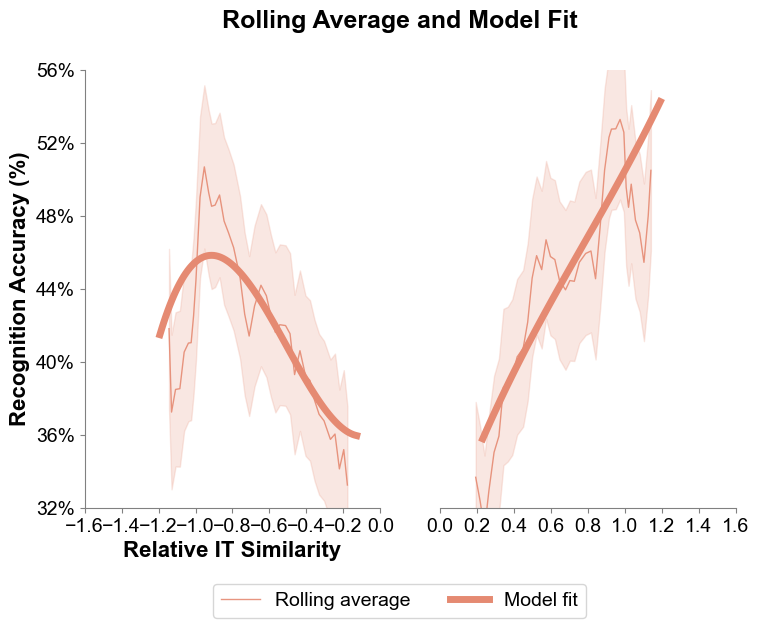

In [115]:
fig_it_simple = combined_sliding_window_and_model_fit_split_col_subplot(
    df=df,
    x_col='Tested - Untested IT Distractor Similarity',
    y_col="LTM Accuracy",
    split_col="IT_pos_neg",
    split_value=0,
    y_limits=(0.32, 0.56),
    x_limits_left=(-1.6, 0),
    x_limits_right=(0, 1.6),
    x_tick_step=0.2,
    left_model_order=3,
    right_model_order=3,
    y_as_percentage=True,
    y_percentage_step=4,
    show_titles=False
)

In [116]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter, MultipleLocator

def remove_leading_zero_formatter(x, pos):
    if x == 0:
        return '0'
    elif x > 0:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('0.'):
            return formatted[1:]
        return formatted
    else:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('-0.'):
            return '-' + formatted[2:]
        return formatted

def create_continuous_rolling_plot(df, x_col, y_col, item_col=None, 
                                 window_percent=0.2, step_percent=0.01,
                                 ax=None, 
                                 y_limits=None, x_limits=None,
                                 x_tick_step=None, y_tick_step=None, x_ticks=None,
                                 y_as_percentage=False, y_percentage_step=2,
                                 font_family='Arial',
                                 title_font_size=18, title_font_color='black', title_font_weight='bold',
                                 label_font_size=16, label_font_color='black', label_font_weight='bold',
                                 tick_font_size=14, tick_font_color='black',
                                 line_width=3, confidence_alpha=0.2,
                                 show_title=True):
    
    # Updated color assignments
    if "Tested - Untested IT" in x_col:
        palette = ['#e58a72']  # salmon for IT
    elif "Tested - Untested V2"  in x_col:
        palette = ['#dbad40']  # gold for V2
    else:
        palette = ['#e58a72']  # default to salmon
        
    fig = combined_rolling_average_subplot(
        df=df, 
        x_col=x_col, 
        y_col=y_col, 
        item_col=item_col,
        window_percent=window_percent, 
        step_percent=step_percent,
        palette=palette,
        ax=ax, 
        show_title=False,
        show_xlabel=True,
        font_family=font_family, 
        title_font_size=title_font_size, 
        title_font_color=title_font_color, 
        title_font_weight=title_font_weight,
        label_font_size=label_font_size, 
        label_font_color=label_font_color, 
        label_font_weight=label_font_weight,
        tick_font_size=tick_font_size-2,
        tick_font_color=tick_font_color,
        y_as_percentage=y_as_percentage, 
        y_percentage_step=y_percentage_step, 
        x_tick_step=x_tick_step, 
        y_tick_step=y_tick_step,
        x_limits=x_limits, 
        y_limits=y_limits,
        line_width=line_width, 
        confidence_alpha=confidence_alpha
    )
    
    ax.axvline(x=0, color='grey', linestyle='--', alpha=0.7, linewidth=3)
    
    if show_title:
        ax.set_title("Continuous", fontsize=title_font_size-2, 
                    color=title_font_color, fontweight=title_font_weight, 
                    fontfamily=font_family, pad=15)
    
    ax.set_xlabel('')
    ax.tick_params(axis='x', bottom=False, labelbottom=False)
    ax.spines['bottom'].set_visible(False)
    
    return ax

def create_single_side_plot(df, x_col, y_col, item_col=None, 
                           split_col='v2_pos_neg', split_value=0, side='left',
                                                            window_percent=0.2, step_percent=0.01,
                           ax=None, palette=None,
                           y_limits=None, x_limits=None,
                           x_tick_step=None, y_tick_step=None,
                           trim_percentile=0,
                           y_as_percentage=False, y_percentage_step=2,
                           x_buffer_percent=0.05,
                           font_family='Arial',
                           title_font_size=18, title_font_color='black', title_font_weight='bold',
                           label_font_size=16, label_font_color='black', label_font_weight='bold',
                           tick_font_size=14, tick_font_color='black',
                           rolling_line_width=1, model_line_width=5,
                           confidence_alpha=0.2, rolling_alpha=0.9,
                           show_title=True, show_ylabel=True, show_xlabel=True,
                           grey_out_model=False, 
                           fitted_model=None):  # NEW: Accept pre-fitted model
    
    grey = '#BFBFBF'
    blue = '#6cbcef'
    teal = '#49a791'
    purple = '#a271b1'
    salmon = '#e58a72'  # IT color
    gold = '#dbad40'    # V2 color
    green = '#95c355'
    
    if palette is None:
        # Updated color assignments
        if "IT Distractor Similarity" in x_col:
            default_colors = [salmon, grey]  # salmon for IT
        elif "V2 Distractor Similarity" in x_col:
            default_colors = [gold, grey]    # gold for V2
        else:
            default_colors = [salmon, grey]  # default to salmon
    else:
        default_colors = palette
    
    color_map = {
        'prioritized': default_colors[0],    
        'deprioritized': default_colors[1] if len(default_colors) > 1 else grey,  
    }
    
    if side == 'left':
        df_side = df[df[x_col] <= split_value].copy()
        title_text = f"{x_col} ≤ {split_value}"
    else:
        df_side = df[df[x_col] > split_value].copy()
        title_text = f"{x_col} > {split_value}"
    
    ax.set_facecolor('white')
    
    item_color_dict = {}
    if item_col is not None and item_col in df.columns:
        all_items = df[item_col].unique()
        for i, item in enumerate(all_items):
            item_lower = str(item).lower()
            if item_lower in color_map:
                item_color_dict[item] = color_map[item_lower]
            elif 'prioritized' in item_lower:
                item_color_dict[item] = color_map['prioritized']
            elif 'deprioritized' in item_lower:
                item_color_dict[item] = color_map['deprioritized']
            else:
                item_color_dict[item] = default_colors[i % len(default_colors)]
    
    # Rolling averages (same as before)
    if item_col is not None and item_col in df.columns:
        items = df_side[item_col].unique()
        
        for i, item in enumerate(items):
            df_item = df_side[df_side[item_col] == item].copy()
            df_item = df_item.sort_values(by=x_col).reset_index(drop=True)
            total_points = len(df_item)
            
            window_points = max(int(total_points * window_percent), 3)
            step_points = max(int(total_points * step_percent), 1)
            color = item_color_dict.get(item, default_colors[i % len(default_colors)])
            
            if total_points >= window_points:
                print(f"{side} side - {item}, Total points: {total_points}, "
                      f"Window size: {window_points}, Step size: {step_points}")
                
                x_vals, y_vals, y_errs = [], [], []
                for j in range(0, total_points - window_points + 1, step_points):
                    window = df_item.iloc[j:j+window_points]
                    mean_x = window[x_col].mean()
                    mean_y = window[y_col].mean()
                    std_y = window[y_col].std()
                    sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                    x_vals.append(mean_x)
                    y_vals.append(mean_y)
                    y_errs.append(sem_y)
                
                x_vals = np.array(x_vals)
                y_vals = np.array(y_vals)
                y_errs = np.array(y_errs)
                
                if len(x_vals) > 0:
                    ax.plot(x_vals, y_vals, color=color, linewidth=rolling_line_width, 
                           alpha=rolling_alpha, label=f'{item} (rolling)')
                    ax.fill_between(x_vals, 
                                   y_vals - 1.96 * y_errs,
                                   y_vals + 1.96 * y_errs,
                                   color=color, alpha=confidence_alpha)
        
        # Plot model fits using the pre-fitted model
        if not grey_out_model and fitted_model is not None:
            for i, item in enumerate(items):
                df_item = df_side[df_side[item_col] == item].copy()
                color = item_color_dict.get(item, default_colors[i % len(default_colors)])
                
                if len(df_item) > 0:
                    # Get the x-range for this side and item
                    x_min = df_item[x_col].min()
                    x_max = df_item[x_col].max()
                    
                    if x_max > x_min:
                        x_range = np.linspace(x_min, x_max, 100)
                        y_model = fitted_model(x_range)
                        ax.plot(x_range, y_model, color=color, linestyle='-', 
                                linewidth=model_line_width, label=f'{item} (model)')
    else:
        # Handle case without item_col
        df_side_copy = df_side.copy().sort_values(by=x_col).reset_index(drop=True)
        total_points = len(df_side_copy)
        
        window_points = max(int(total_points * window_percent), 3)
        step_points = max(int(total_points * step_percent), 1)
        color = default_colors[0]
        
        if total_points >= window_points:
            print(f"{side} side - All Data, Total points: {total_points}, "
                  f"Window size: {window_points}, Step size: {step_points}")
            
            x_vals, y_vals, y_errs = [], [], []
            for j in range(0, total_points - window_points + 1, step_points):
                window = df_side_copy.iloc[j:j+window_points]
                mean_x = window[x_col].mean()
                mean_y = window[y_col].mean()
                std_y = window[y_col].std()
                sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                x_vals.append(mean_x)
                y_vals.append(mean_y)
                y_errs.append(sem_y)
            
            x_vals = np.array(x_vals)
            y_vals = np.array(y_vals)
            y_errs = np.array(y_errs)
            
            if len(x_vals) > 0:
                ax.plot(x_vals, y_vals, color=color, linewidth=rolling_line_width, 
                       alpha=rolling_alpha, label='Rolling average')
                ax.fill_between(x_vals, 
                               y_vals - 1.96 * y_errs,
                               y_vals + 1.96 * y_errs,
                               color=color, alpha=confidence_alpha)
        
        # Plot model fit using the pre-fitted model
        if not grey_out_model and fitted_model is not None:
            if len(df_side_copy) > 0:
                x_min = df_side_copy[x_col].min()
                x_max = df_side_copy[x_col].max()
                
                if x_max > x_min:
                    x_range = np.linspace(x_min, x_max, 100)
                    y_model = fitted_model(x_range)
                    ax.plot(x_range, y_model, color=color, linestyle='-', 
                            linewidth=model_line_width, label='Model fit')
    
    if show_title:
        if side == 'left':
            ax.set_title("Negative", fontsize=title_font_size, 
                        color=title_font_color, fontweight=title_font_weight, 
                        fontfamily=font_family, pad=20)
        else:
            ax.set_title("Positive", fontsize=title_font_size, 
                        color=title_font_color, fontweight=title_font_weight, 
                        fontfamily=font_family, pad=20)
    
    if show_xlabel:
        if x_col in ["Tested - Untested IT Distractor Similarity"]:
            ax.set_xlabel("Relative IT Similarity", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif x_col in ["Tested - Untested V2 Distractor Similarity"]:
            ax.set_xlabel("Relative V2 Similarity", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        else:
            ax.set_xlabel(x_col, fontweight=label_font_weight, fontsize=label_font_size, 
                         color=label_font_color, fontfamily=font_family, labelpad=15)
    else:
        ax.set_xlabel('')
    
    if show_ylabel:
        if y_col.lower() in ['accuracy']:
            if y_as_percentage:
                ax.set_ylabel("Choice Accuracy (% Correct)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
                ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
                if y_tick_step is None:
                    y_tick_step = y_percentage_step / 100.0
            else:
                ax.set_ylabel("Choice Accuracy (% Correct)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif y_col.lower() in ['wm rt']:
            ax.set_ylabel("Response Time (msec)", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif y_col.lower() in ['error category accuracy']:
            if y_as_percentage:
                ax.set_ylabel("Within Category Errors (%)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
                ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
                if y_tick_step is None:
                    y_tick_step = y_percentage_step / 100.0
            else:
                ax.set_ylabel("Within Category Errors", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        else:
            ax.set_ylabel(y_col, fontweight=label_font_weight, fontsize=label_font_size, 
                         color=label_font_color, fontfamily=font_family, labelpad=15)
    
    if x_tick_step is not None:
        ax.xaxis.set_major_locator(MultipleLocator(x_tick_step))
    if y_tick_step is not None:
        ax.yaxis.set_major_locator(MultipleLocator(y_tick_step))
    
    # Handle x-limits with buffer space from y-axis
    if x_limits is not None:
        if side == 'left':
            x_min, x_max = x_limits[0], split_value
            x_range = abs(x_max - x_min)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(x_min - buffer, x_max)
        else:
            x_min, x_max = split_value, x_limits[1]
            x_range = abs(x_max - x_min)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(x_min - buffer, x_max)
    else:
        if side == 'left':
            data_x_min = df_side[x_col].min()
            x_range = abs(split_value - data_x_min)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(data_x_min - buffer, split_value)
        else:
            data_x_max = df_side[x_col].max()
            x_range = abs(data_x_max - split_value)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(split_value - buffer, data_x_max)
    
    # Handle y-limits
    if y_limits is not None:
        ax.set_ylim(y_limits)
    elif y_col.lower() in ['accuracy', 'acc', 'correct', 'resp_correct']:
        ax.set_ylim(0.6, 0.8)
    
    ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    spine_color = '#B8B8B8'
    ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
    ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
    
    for label in ax.get_xticklabels():
        label.set_fontfamily(font_family)
    for label in ax.get_yticklabels():
        label.set_fontfamily(font_family)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color(spine_color)
    ax.spines['left'].set_color(spine_color)
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.grid(False)
    
    return ax

def create_three_panel_visualization(plot_configs, middle_width=0.35, middle_height_shift=0.0, 
                                   middle_size_scale=0.7, adjustable_gap=0.01, 
                                   grey_out_models=None, x_buffer_percent=0.05):
    """
    Create three-panel visualization showing only the first row with same panel sizes.
    Now fits a single model to the entire dataset and displays portions on left/right.
    """
    
    from matplotlib.gridspec import GridSpec
    
    fig = plt.figure(figsize=(18, 6.3))
    
    # Keep plot sizes FIXED regardless of gap size
    original_gap_width = 0.01
    original_remaining_width = 1.0 - middle_width - 2*original_gap_width
    fixed_side_width = original_remaining_width / 2 * 0.6
    fixed_middle_width = middle_width
    
    current_gap_width = adjustable_gap
    
    total_plot_width = 2 * fixed_side_width + fixed_middle_width + 2 * current_gap_width
    remaining_for_margins = 1.0 - total_plot_width
    outer_margin = remaining_for_margins / 2
    
    if outer_margin < 0.001:
        outer_margin = 0.001
    
    # Single row GridSpec
    gs = GridSpec(1, 7, figure=fig, 
                  width_ratios=[outer_margin, fixed_side_width, current_gap_width, fixed_middle_width, current_gap_width, fixed_side_width, outer_margin],  
                  height_ratios=[1],   
                  hspace=0.0, wspace=0.01,
                  top=0.95, bottom=0.1, left=0.05, right=0.95)
    
    # Create axes for single row
    ax_left = fig.add_subplot(gs[0, 1])
    ax_middle = fig.add_subplot(gs[0, 3])
    ax_right = fig.add_subplot(gs[0, 5])
    axes = [[ax_left, ax_middle, ax_right]]
    
    all_handles = []
    all_labels = []
    
    # Initialize grey_out_models if not provided
    if grey_out_models is None:
        grey_out_models = {}
    
    # Process only the first config
    config = plot_configs[0]
    row = 0
    
    x_col = config['x_col']
    y_col = config['y_col']
    
    # Updated frame colors
    if "IT Distractor Similarity" in x_col:
        frame_color = '#e58a72'  # salmon for IT
        model_order = 2  # IT uses order 2
    elif "V2 Distractor Similarity" in x_col:
        frame_color = '#dbad40'  # gold for V2
        model_order = 3  # V2 uses order 3
    else:
        frame_color = '#e58a72'  # default to salmon
        model_order = 2  # default order
    
    y_limits = config.get('y_limits')
    
    # FIT MODEL TO ENTIRE DATASET
    df_full = config['df'].copy()
    trim_percentile = config.get('trim_percentile', 0)
    
    # Apply trimming if specified
    if trim_percentile > 0:
        lower_p = np.percentile(df_full[x_col], trim_percentile)
        upper_p = np.percentile(df_full[x_col], 100 - trim_percentile)
        df_trimmed = df_full[(df_full[x_col] >= lower_p) & (df_full[x_col] <= upper_p)]
    else:
        df_trimmed = df_full
    
    # Fit model to entire dataset
    fitted_model = None
    if len(df_trimmed) >= 5:
        print(f"Fitting model to entire dataset:")
        print(f"  Total points: {len(df_full)}")
        if trim_percentile > 0:
            print(f"  After trimming ({trim_percentile}%): {len(df_trimmed)}")
        print(f"  Model order: {model_order}")
        
        # Fit polynomial model to entire dataset
        coeffs = np.polyfit(df_trimmed[x_col], df_trimmed[y_col], model_order)
        fitted_model = np.poly1d(coeffs)
        print(f"  Model coefficients: {coeffs}")
    
    # Check if left/right sides should be greyed out
    grey_left = grey_out_models.get(row, {}).get('left', False)
    grey_right = grey_out_models.get(row, {}).get('right', False)
    
    # Create left panel with portion of global model
    create_single_side_plot(
        config['df'],
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config.get('item_col'),
        side='left',
        ax=axes[row][0],
        y_limits=y_limits,
        x_limits=config.get('x_limits'),
        x_tick_step=config.get('x_tick_step'),
        y_tick_step=config.get('y_tick_step'),
        trim_percentile=trim_percentile,
        window_percent=0.2,  # Fixed to 0.2
        step_percent=0.02,   # Fixed to 0.01
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        x_buffer_percent=x_buffer_percent,
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 16),
        tick_font_size=config.get('tick_font_size', 14),
        show_title=False,
        show_ylabel=True,
        show_xlabel=False,
        grey_out_model=grey_left,
        fitted_model=fitted_model  # Pass the global model
    )
    if config.get('y_as_percentage', False):
            axes[row][0].yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
            if config.get('y_tick_step') is None and config.get('y_percentage_step'):
                y_tick_step = config.get('y_percentage_step', 2) / 100.0
                axes[row][0].yaxis.set_major_locator(MultipleLocator(y_tick_step))
        
    axes[row][0].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    # Create middle panel (continuous rolling plot) - unchanged
    create_continuous_rolling_plot(
        config['df'],
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config.get('item_col'),
        ax=axes[row][1],
        y_limits=y_limits,
        x_limits=config.get('x_limits'),
        x_tick_step=config.get('x_tick_step'),
        y_tick_step=config.get('y_tick_step'),
        x_ticks=config.get('x_ticks'),
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 14),
        tick_font_size=config.get('tick_font_size', 12),
        window_percent=0.1,  # Fixed to 0.2
        step_percent=0.01,   # Fixed to 0.01
        line_width=2,
        show_title=False
    )
    
    axes[row][1].set_xlabel('')
    axes[row][1].tick_params(axis='x', bottom=False, labelbottom=False)
    axes[row][1].spines['bottom'].set_visible(False)
    
    for spine_name, spine in axes[row][1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(5)
        spine.set_color(frame_color)
    
    axes[row][1].set_facecolor('#f8f8f8')
    
    pos = axes[row][1].get_position()
    new_width = pos.width * middle_size_scale
    new_height = pos.height * middle_size_scale
    new_x = pos.x0 + (pos.width - new_width) / 2
    new_y = pos.y0 + middle_height_shift
    
    new_pos = [new_x, new_y, new_width, new_height]
    axes[row][1].set_position(new_pos)
    
    # Create right panel with portion of global model
    create_single_side_plot(
        config['df'],
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config.get('item_col'),
        side='right',
        ax=axes[row][2],
        y_limits=y_limits,
        x_limits=config.get('x_limits'),
        x_tick_step=config.get('x_tick_step'),
        y_tick_step=config.get('y_tick_step'),
        trim_percentile=trim_percentile,
        window_percent=0.2,  # Fixed to 0.2
        step_percent=0.02,   # Fixed to 0.01
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        x_buffer_percent=x_buffer_percent,
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 16),
        tick_font_size=config.get('tick_font_size', 14),
        show_title=False,
        show_ylabel=False,
        show_xlabel=False,
        grey_out_model=grey_right,
        fitted_model=fitted_model  # Pass the global model
    )
    if config.get('y_as_percentage', False):
            axes[row][2].yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
            if config.get('y_tick_step') is None and config.get('y_percentage_step'):
                y_tick_step = config.get('y_percentage_step', 2) / 100.0
                axes[row][2].yaxis.set_major_locator(MultipleLocator(y_tick_step))
        
 
              
    axes[row][2].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    axes[row][1].set_ylabel('')
    axes[row][1].tick_params(axis='y', labelleft=False, left=False)
    
    axes[row][2].set_ylabel('')
    axes[row][2].tick_params(axis='y', labelleft=False, left=False)
    axes[row][2].spines['left'].set_visible(False)
    
    for col in range(3):
        handles, labels = axes[row][col].get_legend_handles_labels()
        for handle, label in zip(handles, labels):
            if "(" in label:
                base_label = label.split("(")[0].strip()
            else:
                base_label = label
            if base_label not in all_labels:
                all_handles.append(handle)
                all_labels.append(base_label)
    
    axes[row][0].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    axes[row][2].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    plt.show()
    return fig

# Usage example - now with single model fit to entire dataset
# fig_it = create_three_panel_visualization(
#     plot_configs_it,  # Only first config will be plotted
#     middle_width=0.35,
#     middle_height_shift=0.05,
#     middle_size_scale=0.5,
#     adjustable_gap=-0.03,
#     grey_out_models={0: {'right': True, 'left': False}},  # Now refers to the single row (row 0)
#     x_buffer_percent=0.05
# )

In [117]:


plot_configs_it = [
    {
        'df': df,
        'x_col': 'Tested - Untested IT Distractor Similarity',
        'y_col': "LTM Accuracy",
        'y_label': "Recognition Accuracy\n (% Correct)",
        # 'item_col': "Tested Item",
        'split_col': "IT_pos_neg",
        'split_value': 0,
        'y_limits': (0.3, 0.6), # Custom y-axis limits
        'x_limits': (-1.4, 1.4),  # Combined x limits
        'x_tick_step': 0.4,           # X-axis ticks every 0.2
        'left_model_order': 3,         # 3rd order polynomial for left side
        'right_model_order': 3,        # 3rd order polynomial for right side
        'trim_percentile': 0,          # Remove extreme 0% from each tail
        'y_as_percentage': True,       # Format as percentages
        'y_percentage_step': 5,        # Every 2%
        'font_family': 'Arial',
        'label_font_size': 28,         # Increased from 14
        'tick_font_size': 26           # Increased from 12
    }, 
    {
        'df': df,
        'x_col': 'Tested - Untested IT Distractor Similarity',
        'y_col': "LTM Accuracy",
        'y_label': "Recognition Accuracy\n (% Correct)",

        # 'item_col': "Tested Item",
        'split_col': "IT_pos_neg",
        'split_value': 0,
        'y_limits': (0.3, 0.6), # Custom y-axis limits
        'x_limits': (-1.4, 1.4),  # Combined x limits
        'x_tick_step': 0.4,           # X-axis ticks every 0.2
        'left_model_order': 3,         # 3rd order polynomial for left side
        'right_model_order': 3,        # 3rd order polynomial for right side
        'trim_percentile': 0,          # Remove extreme 0% from each tail
        'y_as_percentage': True,       # Format as percentages
        'y_percentage_step': 2,        # Every 2%
        'font_family': 'Arial',
        'label_font_size': 28,         # Increased from 14
        'tick_font_size': 26           # Increased from 12
    },
    {
        'df': df,
        'x_col': 'Tested - Untested IT Distractor Similarity',
        'y_col': "LTM Accuracy",        
        'y_label': "Recognition Accuracy\n (% Correct)",

        # 'item_col': "Tested Item",
        'split_col': "IT_pos_neg",
        'split_value': 0,
        'y_limits': (0.3, 0.6), # Custom y-axis limits
        'x_limits': (-1.4, 1.4),  # Combined x limits
        'x_tick_step': 0.4,           # X-axis ticks every 0.2
        'left_model_order': 3,         # 3rd order polynomial for left side
        'right_model_order': 3,        # 3rd order polynomial for right side
        'trim_percentile': 0,          # Remove extreme 0% from each tail
        'y_as_percentage': True,       # Format as percentages
        'y_percentage_step': 2,        # Every 2%
        'font_family': 'Arial',
        'label_font_size': 28,         # Increased from 14
        'tick_font_size': 26           # Increased from 12
    }
]

plot_configs_v2 = [
    {
        'df': df,
        'x_col': 'Tested - Untested V2 Distractor Similarity',
        'y_col': "LTM Accuracy",
        # 'item_col': "Tested Item",
        'y_label': "Recognition Accuracy\n (% Correct)",

        'split_col': "V2_pos_neg",
        'split_value': 0,
        'y_limits': (0.3, 0.6), # Custom y-axis limits
        'x_limits': (-0.2, 0.2),   # Combined x limits
        'x_tick_step': 0.06,           # X-axis ticks every 0.04
        'left_model_order': 3,         # 3rd order polynomial for left side
        'right_model_order': 3,        # 3rd order polynomial for right side
        'trim_percentile': 0,          # Remove extreme 0% from each tail
        'y_as_percentage': True,       # Format as percentages
        'y_percentage_step': 5,        # Every 2%
        'font_family': 'Arial',
        'label_font_size': 28,         # Increased from 14
        'tick_font_size': 26           # Increased from 12
    },
    {
        'df': df,
        'x_col': 'Tested - Untested V2 Distractor Similarity',
        'y_col': "LTM Accuracy",
        # 'item_col': "Tested Item",      
        'y_label': "Recognition Accuracy\n (% Correct)",

        'split_col': "V2_pos_neg",
        'split_value': 0,
        'y_limits': (0.3, 0.55), # Custom y-axis limits
        'x_limits': (-0.2, 0.2),   # Combined x limits
        'x_tick_step': 0.06,           # X-axis ticks every 0.04
        'left_model_order': 3,         # 3rd order polynomial for left side
        'right_model_order': 3,        # 3rd order polynomial for right side
        'trim_percentile': 0,          # Remove extreme 0% from each tail
        'y_as_percentage': True,       # Format as percentages
        'y_percentage_step': 2,        # Every 2%
        'font_family': 'Arial',
        'label_font_size': 28,         # Increased from 14
        'tick_font_size': 26           # Increased from 12
    },
    {
        'df': df,
        'x_col': 'Tested - Untested V2 Distractor Similarity',
        'y_col': "LTM Accuracy",       
        'y_label': "Recognition Accuracy\n (% Correct)",

        # 'item_col': "Tested Item",
        'split_col': "V2_pos_neg",
        'split_value': 0,
        'y_limits': (0.3, 0.55), # Custom y-axis limits
        'x_limits': (-0.2, 0.2),   # Combined x limits
        'x_tick_step': 0.06,           # X-axis ticks every 0.04
        'left_model_order': 3,         # 3rd order polynomial for left side
        'right_model_order': 3,        # 3rd order polynomial for right side
        'trim_percentile': 0,          # Remove extreme 0% from each tail
        'y_as_percentage': True,       # Format as percentages
        'y_percentage_step': 2,        # Every 2%
        'font_family': 'Arial',
        'label_font_size': 28,         # Increased from 14
        'tick_font_size': 26           # Increased from 12
    }
]

In [118]:
# fig_it = create_three_panel_visualization(
#     plot_configs_it,  # Only first config will be plotted
#     middle_width=0.35,
#     middle_height_shift=0.05,
#     middle_size_scale=0.5,
#     adjustable_gap=-0.03,
#     grey_out_models={0: {'right': False, 'left': False}},  # Now refers to the single row (row 0)
#     x_buffer_percent=0.05
# )

In [119]:

# fig_v2 = create_three_panel_visualization(
#     plot_configs_v2,  # Only first config will be plotted
#     middle_width=0.35,
#     middle_height_shift=0.05,
#     middle_size_scale=0.5,
#     adjustable_gap=-0.03,
#     grey_out_models={0: {'right': False, 'left': False}},  # Now refers to the single row (row 0)
#     x_buffer_percent=0.05
# )

In [186]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter, MultipleLocator
from matplotlib.gridspec import GridSpec

def remove_leading_zero_formatter(x, pos):
    if x == 0:
        return '0'
    elif x > 0:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('0.'):
            return formatted[1:]
        return formatted
    else:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('-0.'):
            return '-' + formatted[2:]
        return formatted

def combined_rolling_average_subplot(df, x_col, y_col, item_col=None, 
                                   window_percent=0.1, step_percent=0.02,
                                   palette=None, ax=None, 
                                   show_title=True, show_xlabel=True,
                                   font_family='Arial', 
                                   title_font_size=18, title_font_color='black', title_font_weight='bold',
                                   label_font_size=16, label_font_color='black', label_font_weight='bold',
                                   tick_font_size=14, tick_font_color='black',
                                   y_as_percentage=True, y_percentage_step=2, 
                                   x_tick_step=None, y_tick_step=None,
                                   x_limits=None, y_limits=None, x_ticks=None,
                                   line_width=3, confidence_alpha=0.2):
    
    # Use updated colors
    if palette is None:
        if "IT Distractor Similarity" in x_col:
            palette = ['#E58A72']
        elif "V2 Distractor Similarity" in x_col:
            palette = ['#A283B3']
        else:
            palette = ['#E58A72']
    
    grey = '#BFBFBF'
    
    # Color mapping
    item_color_dict = {}
    if item_col is not None and item_col in df.columns:
        all_items = df[item_col].unique()
        for i, item in enumerate(all_items):
            item_lower = str(item).lower()
            if 'prioritized' in item_lower:
                item_color_dict[item] = palette[0]
            elif 'deprioritized' in item_lower:
                item_color_dict[item] = grey
            else:
                item_color_dict[item] = palette[i % len(palette)]
    
    # Create rolling averages
    if item_col is not None and item_col in df.columns:
        items = df[item_col].unique()
        
        for i, item in enumerate(items):
            df_item = df[df[item_col] == item].copy()
            df_item = df_item.sort_values(by=x_col).reset_index(drop=True)
            total_points = len(df_item)
            
            window_points = max(int(total_points * window_percent), 3)
            step_points = max(int(total_points * step_percent), 1)
            color = item_color_dict.get(item, palette[i % len(palette)])
            
            if total_points >= window_points:
                x_vals, y_vals, y_errs = [], [], []
                for j in range(0, total_points - window_points + 1, step_points):
                    window = df_item.iloc[j:j+window_points]
                    mean_x = window[x_col].mean()
                    mean_y = window[y_col].mean()
                    std_y = window[y_col].std()
                    sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                    x_vals.append(mean_x)
                    y_vals.append(mean_y)
                    y_errs.append(sem_y)
                
                x_vals = np.array(x_vals)
                y_vals = np.array(y_vals)
                y_errs = np.array(y_errs)
                
                if len(x_vals) > 0:
                    ax.plot(x_vals, y_vals, color=color, linewidth=line_width, 
                           label=f'{item}')
                    ax.fill_between(x_vals, 
                                   y_vals - 1.96 * y_errs,
                                   y_vals + 1.96 * y_errs,
                                   color=color, alpha=confidence_alpha)
    else:
        # Handle case with no item_col
        df_sorted = df.sort_values(by=x_col).reset_index(drop=True)
        total_points = len(df_sorted)
        
        window_points = max(int(total_points * window_percent), 3)
        step_points = max(int(total_points * step_percent), 1)
        color = palette[0]
        
        if total_points >= window_points:
            x_vals, y_vals, y_errs = [], [], []
            for j in range(0, total_points - window_points + 1, step_points):
                window = df_sorted.iloc[j:j+window_points]
                mean_x = window[x_col].mean()
                mean_y = window[y_col].mean()
                std_y = window[y_col].std()
                sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                x_vals.append(mean_x)
                y_vals.append(mean_y)
                y_errs.append(sem_y)
            
            x_vals = np.array(x_vals)
            y_vals = np.array(y_vals)
            y_errs = np.array(y_errs)
            
            if len(x_vals) > 0:
                ax.plot(x_vals, y_vals, color=color, linewidth=line_width, 
                       label='Rolling average')
                ax.fill_between(x_vals, 
                               y_vals - 1.96 * y_errs,
                               y_vals + 1.96 * y_errs,
                               color=color, alpha=confidence_alpha)
    
    return ax

def create_continuous_rolling_plot(df, x_col, y_col, item_col=None, 
                                 window_percent=0.1, step_percent=0.02,
                                 ax=None, 
                                 y_limits=None, x_limits=None,
                                 x_tick_step=None, y_tick_step=None, x_ticks=None,
                                 y_as_percentage=True, y_percentage_step=2,
                                 font_family='Arial',
                                 title_font_size=18, title_font_color='black', title_font_weight='bold',
                                 label_font_size=16, label_font_color='black', label_font_weight='bold',
                                 tick_font_size=14, tick_font_color='black',
                                 line_width=3, confidence_alpha=0.2,
                                 show_title=True):
    
    if "IT Distractor Similarity" in x_col:
        palette = ['#E58A72']
    elif "V2 Distractor Similarity" in x_col:
        palette = ['#A283B3']
    else:
        palette = ['#E58A72']
    
    fig = combined_rolling_average_subplot(
        df=df, 
        x_col=x_col, 
        y_col=y_col, 
        item_col=item_col,
        window_percent=window_percent, 
        step_percent=step_percent,
        palette=palette,
        ax=ax, 
        show_title=False,
        show_xlabel=True,
        font_family=font_family, 
        title_font_size=title_font_size, 
        title_font_color=title_font_color, 
        title_font_weight=title_font_weight,
        label_font_size=label_font_size, 
        label_font_color=label_font_color, 
        label_font_weight=label_font_weight,
        tick_font_size=tick_font_size-2,
        tick_font_color=tick_font_color,
        y_as_percentage=y_as_percentage, 
        y_percentage_step=y_percentage_step, 
        x_tick_step=x_tick_step, 
        y_tick_step=y_tick_step,
        x_limits=x_limits, 
        y_limits=y_limits,
        x_ticks=x_ticks,
        line_width=line_width, 
        confidence_alpha=confidence_alpha
    )
    
    ax.axvline(x=0, color='grey', linestyle='--', alpha=0.7, linewidth=3)
    
    if show_title:
        ax.set_title("Continuous", fontsize=title_font_size-2, 
                    color=title_font_color, fontweight=title_font_weight, 
                    fontfamily=font_family, pad=15)
    
    ax.set_xlabel('')
    ax.tick_params(axis='x', bottom=False, labelbottom=False)
    ax.spines['bottom'].set_visible(False)
    
    return ax

def create_single_side_plot(df, x_col, y_col, item_col=None, 
                           split_col='v2_pos_neg', split_value=0, side='left',
                           window_percent=0.2, step_percent=0.02,
                           ax=None, palette=None,
                           y_limits=None, x_limits=None,
                           x_tick_step=None, y_tick_step=None,
                           model_order=2, trim_percentile=0,
                           y_as_percentage=True, y_percentage_step=2,
                           x_buffer_percent=0.05,
                           font_family='Arial',
                           title_font_size=18, title_font_color='black', title_font_weight='bold',
                           label_font_size=16, label_font_color='black', label_font_weight='bold',
                           tick_font_size=14, tick_font_color='black',
                           rolling_line_width=1, model_line_width=5,
                           confidence_alpha=0.2, rolling_alpha=0.9,
                           show_title=True, show_ylabel=True, show_xlabel=True,
                           grey_out_model=False,
                           fitted_model=None,
                           y_label=None):  # Added y_label parameter
    
    grey = '#BFBFBF'
    blue = '#6cbcef'
    teal = '#49a791'
    purple = '#A283B3'  # Updated V2 color
    salmon = '#E58A72'  # Updated IT color
    gold = '#dbad40'
    green = '#95c355'
    
    if palette is None:
        if "IT Distractor Similarity" in x_col:
            default_colors = [salmon, grey]  # Use updated IT color
        elif "V2 Distractor Similarity" in x_col:
            default_colors = [purple, grey]  # Use updated V2 color
        else:
            default_colors = [salmon, grey]  # Use updated IT color as default
    else:
        default_colors = palette
    
    color_map = {
        'prioritized': default_colors[0],    
        'deprioritized': default_colors[1] if len(default_colors) > 1 else grey,  
    }
    
    if side == 'left':
        df_side = df[df[x_col] <= split_value].copy()
        title_text = f"{x_col} ≤ {split_value}"
    else:
        df_side = df[df[x_col] > split_value].copy()
        title_text = f"{x_col} > {split_value}"
    
    ax.set_facecolor('white')
    
    item_color_dict = {}
    if item_col is not None and item_col in df.columns:
        all_items = df[item_col].unique()
        for i, item in enumerate(all_items):
            item_lower = str(item).lower()
            if item_lower in color_map:
                item_color_dict[item] = color_map[item_lower]
            elif 'prioritized' in item_lower:
                item_color_dict[item] = color_map['prioritized']
            elif 'deprioritized' in item_lower:
                item_color_dict[item] = color_map['deprioritized']
            else:
                item_color_dict[item] = default_colors[i % len(default_colors)]
    
    if item_col is not None and item_col in df.columns:
        items = df_side[item_col].unique()
        
        for i, item in enumerate(items):
            df_item = df_side[df_side[item_col] == item].copy()
            df_item = df_item.sort_values(by=x_col).reset_index(drop=True)
            total_points = len(df_item)
            
            window_points = max(int(total_points * window_percent), 3)
            step_points = max(int(total_points * step_percent), 1)
            color = item_color_dict.get(item, default_colors[i % len(default_colors)])
            
            if total_points >= window_points:
                print(f"{side} side - {item}, Total points: {total_points}, "
                      f"Window size: {window_points}, Step size: {step_points}")
                
                x_vals, y_vals, y_errs = [], [], []
                for j in range(0, total_points - window_points + 1, step_points):
                    window = df_item.iloc[j:j+window_points]
                    mean_x = window[x_col].mean()
                    mean_y = window[y_col].mean()
                    std_y = window[y_col].std()
                    sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                    x_vals.append(mean_x)
                    y_vals.append(mean_y)
                    y_errs.append(sem_y)
                
                x_vals = np.array(x_vals)
                y_vals = np.array(y_vals)
                y_errs = np.array(y_errs)
                
                if len(x_vals) > 0:
                    ax.plot(x_vals, y_vals, color=color, linewidth=rolling_line_width, 
                           alpha=rolling_alpha, label=f'{item} (rolling)')
                    ax.fill_between(x_vals, 
                                   y_vals - 1.96 * y_errs,
                                   y_vals + 1.96 * y_errs,
                                   color=color, alpha=confidence_alpha)
        
        # Model fits
        if not grey_out_model:
            for i, item in enumerate(items):
                df_item = df_side[df_side[item_col] == item].copy()
                color = item_color_dict.get(item, default_colors[i % len(default_colors)])
                
                if fitted_model is not None:
                    # Use the provided fitted model
                    if len(df_item) > 0:
                        x_min, x_max = df_item[x_col].min(), df_item[x_col].max()
                        x_range = np.linspace(x_min, x_max, 100)
                        y_model = fitted_model(x_range)
                        ax.plot(x_range, y_model, color=color, linestyle='-', 
                                linewidth=model_line_width, label=f'{item} (model)')
                else:
                    # Original model fitting logic
                    if trim_percentile > 0:
                        lower_p = np.percentile(df_item[x_col], trim_percentile)
                        upper_p = np.percentile(df_item[x_col], 100 - trim_percentile)
                        df_item_trimmed = df_item[(df_item[x_col] >= lower_p) & (df_item[x_col] <= upper_p)]
                    else:
                        df_item_trimmed = df_item
                    
                    if len(df_item_trimmed) >= 5:
                        x_range = np.linspace(df_item_trimmed[x_col].min(), df_item_trimmed[x_col].max(), 100)
                        model = np.poly1d(np.polyfit(df_item_trimmed[x_col], df_item_trimmed[y_col], model_order))
                        ax.plot(x_range, model(x_range), color=color, linestyle='-', 
                                linewidth=model_line_width, label=f'{item} (model)')
    else:
        # Handle single dataset case
        df_side_copy = df_side.copy().sort_values(by=x_col).reset_index(drop=True)
        total_points = len(df_side_copy)
        
        window_points = max(int(total_points * window_percent), 3)
        step_points = max(int(total_points * step_percent), 1)
        color = default_colors[0]
        
        if total_points >= window_points:
            x_vals, y_vals, y_errs = [], [], []
            for j in range(0, total_points - window_points + 1, step_points):
                window = df_side_copy.iloc[j:j+window_points]
                mean_x = window[x_col].mean()
                mean_y = window[y_col].mean()
                std_y = window[y_col].std()
                sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                x_vals.append(mean_x)
                y_vals.append(mean_y)
                y_errs.append(sem_y)
            
            x_vals = np.array(x_vals)
            y_vals = np.array(y_vals)
            y_errs = np.array(y_errs)
            
            if len(x_vals) > 0:
                ax.plot(x_vals, y_vals, color=color, linewidth=rolling_line_width, 
                       alpha=rolling_alpha, label='Rolling average')
                ax.fill_between(x_vals, 
                               y_vals - 1.96 * y_errs,
                               y_vals + 1.96 * y_errs,
                               color=color, alpha=confidence_alpha)
        
        # Model fit for single dataset
        if not grey_out_model:
            if fitted_model is not None:
                if len(df_side_copy) > 0:
                    x_min, x_max = df_side_copy[x_col].min(), df_side_copy[x_col].max()
                    x_range = np.linspace(x_min, x_max, 100)
                    y_model = fitted_model(x_range)
                    ax.plot(x_range, y_model, color=color, linestyle='-', 
                            linewidth=model_line_width, label='Model fit')
            else:
                if trim_percentile > 0:
                    lower_p = np.percentile(df_side_copy[x_col], trim_percentile)
                    upper_p = np.percentile(df_side_copy[x_col], 100 - trim_percentile)
                    df_side_trimmed = df_side_copy[(df_side_copy[x_col] >= lower_p) & (df_side_copy[x_col] <= upper_p)]
                else:
                    df_side_trimmed = df_side_copy
                
                if len(df_side_trimmed) >= 5:
                    x_range = np.linspace(df_side_trimmed[x_col].min(), df_side_trimmed[x_col].max(), 100)
                    model = np.poly1d(np.polyfit(df_side_trimmed[x_col], df_side_trimmed[y_col], model_order))
                    ax.plot(x_range, model(x_range), color=color, linestyle='-', 
                            linewidth=model_line_width, label='Model fit')
    
    # Set labels and formatting
    if show_title:
        if side == 'left':
            ax.set_title("Negative", fontsize=title_font_size, 
                        color=title_font_color, fontweight=title_font_weight, 
                        fontfamily=font_family, pad=20)
        else:
            ax.set_title("Positive", fontsize=title_font_size, 
                        color=title_font_color, fontweight=title_font_weight, 
                        fontfamily=font_family, pad=20)
    
    if show_xlabel:
        if x_col in ["Tested - Untested IT Distractor Similarity"]:
            ax.set_xlabel("Relative IT Similarity", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif x_col in ["Tested - Untested V2 Distractor Similarity"]:
            ax.set_xlabel("Relative V2 Similarity", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        else:
            ax.set_xlabel(x_col, fontweight=label_font_weight, fontsize=label_font_size, 
                         color=label_font_color, fontfamily=font_family, labelpad=15)
    else:
        ax.set_xlabel('')
    
    if show_ylabel:
        # Modified section to use y_label if provided
        if y_label is not None:
            # Use the provided y_label
            ax.set_ylabel(y_label, fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif y_col.lower() in ['accuracy']:
            if y_as_percentage:
                ax.set_ylabel("Choice Accuracy (% Correct)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
                ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
                if y_tick_step is None:
                    y_tick_step = y_percentage_step / 100.0
            else:
                ax.set_ylabel("Choice Accuracy (% Correct)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif y_col.lower() in ['wm rt']:
            ax.set_ylabel("Response Time (msec)", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        else:
            ax.set_ylabel(y_col, fontweight=label_font_weight, fontsize=label_font_size, 
                         color=label_font_color, fontfamily=font_family, labelpad=15)
    
    # Set tick parameters and limits
    if x_tick_step is not None:
        ax.xaxis.set_major_locator(MultipleLocator(x_tick_step))
    if y_tick_step is not None:
        ax.yaxis.set_major_locator(MultipleLocator(y_tick_step))
    
    # Handle x-limits with buffer space from y-axis
    if x_limits is not None:
        if side == 'left':
            x_min, x_max = x_limits[0], split_value
            x_range = abs(x_max - x_min)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(x_min - buffer, x_max)
        else:
            x_min, x_max = split_value, x_limits[1]
            x_range = abs(x_max - x_min)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(x_min - buffer, x_max)
    else:
        if side == 'left':
            data_x_min = df_side[x_col].min()
            x_range = abs(split_value - data_x_min)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(data_x_min - buffer, split_value)
        else:
            data_x_max = df_side[x_col].max()
            x_range = abs(data_x_max - split_value)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(split_value - buffer, data_x_max)
    
    if y_limits is not None:
        ax.set_ylim(y_limits)
    elif y_col.lower() in ['accuracy', 'acc', 'correct', 'resp_correct']:
        ax.set_ylim(0.6, 0.8)
    
    ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    spine_color = '#B8B8B8'
    ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
    ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
    
    for label in ax.get_xticklabels():
        label.set_fontfamily(font_family)
    for label in ax.get_yticklabels():
        label.set_fontfamily(font_family)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color(spine_color)
    ax.spines['left'].set_color(spine_color)
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.grid(False)
    
    return ax

def create_single_row_visualization(plot_configs, middle_width=0.35, middle_height_shift=0.05, 
                                   middle_size_scale=0.5, adjustable_gap=0.01, 
                                   grey_out_models=None, x_buffer_percent=0.05):
    """
    Create single-row visualization showing only the first row with same panel sizes as three-row version.
    """
    
    fig = plt.figure(figsize=(18, 6))  # Reduced height for tight single row
    
    # Keep plot sizes FIXED regardless of gap size
    original_gap_width = 0.01
    original_remaining_width = 1.0 - middle_width - 2*original_gap_width
    fixed_side_width = original_remaining_width / 2 * 0.6
    fixed_middle_width = middle_width
    
    current_gap_width = adjustable_gap
    
    total_plot_width = 2 * fixed_side_width + fixed_middle_width + 2 * current_gap_width
    remaining_for_margins = 1.0 - total_plot_width
    outer_margin = remaining_for_margins / 2
    
    if outer_margin < 0.001:
        outer_margin = 0.001
    
    # Single row GridSpec with tight margins
    gs = GridSpec(1, 7, figure=fig, 
                  width_ratios=[outer_margin, fixed_side_width, current_gap_width, fixed_middle_width, current_gap_width, fixed_side_width, outer_margin],  
                  height_ratios=[1],   # Single row
                  hspace=0, wspace=0.01,  # No vertical spacing needed
                  top=0.98, bottom=0.02, left=0.05, right=0.95)  # Tight vertical margins
    
    # Create axes for single row
    ax_left = fig.add_subplot(gs[0, 1])
    ax_middle = fig.add_subplot(gs[0, 3])
    ax_right = fig.add_subplot(gs[0, 5])
    axes = [ax_left, ax_middle, ax_right]
    
    all_handles = []
    all_labels = []
    
    # Initialize grey_out_models if not provided
    if grey_out_models is None:
        grey_out_models = {}
    
    # Process only the first config
    config = plot_configs[0]
    row = 0
    
    x_col = config['x_col']
    y_col = config['y_col']
    y_label = config.get('y_label')  # Get y_label from config
    
    # Updated frame colors
    if "IT Distractor Similarity" in x_col:
        frame_color = '#E58A72'  # Updated IT color
        model_order = 2  # IT uses order 2
    elif "V2 Distractor Similarity" in x_col:
        frame_color = '#A283B3'  # Updated V2 color
        model_order = 3  # V2 uses order 3
    else:
        frame_color = '#E58A72'  # Updated IT color as default
        model_order = 2  # default order
    
    y_limits = config.get('y_limits')
    
    # FIT MODEL TO TRANSFORMED (ALL POSITIVE) DATA
    df_full = config['df'].copy()
    trim_percentile = config.get('trim_percentile', 0)
    
    # Apply trimming if specified
    if trim_percentile > 0:
        lower_p = np.percentile(df_full[x_col], trim_percentile)
        upper_p = np.percentile(df_full[x_col], 100 - trim_percentile)
        df_trimmed = df_full[(df_full[x_col] >= lower_p) & (df_full[x_col] <= upper_p)]
    else:
        df_trimmed = df_full
    
    # Transform x data to all positive values
    x_transformed = np.where(df_trimmed[x_col] <= 0, -1, 1) * df_trimmed[x_col]
    x_transformed = np.abs(df_trimmed[x_col])  # Make all values positive
    
    # Fit model to transformed data
    fitted_model_positive = None
    fitted_model_negative = None
    
    if len(df_trimmed) >= 5:
        print(f"Row {row} - Fitting model to transformed (all positive) data:")
        print(f"  Total points: {len(df_full)}")
        if trim_percentile > 0:
            print(f"  After trimming ({trim_percentile}%): {len(df_trimmed)}")
        print(f"  Model order: {model_order}")
        print(f"  X range before transform: [{df_trimmed[x_col].min():.3f}, {df_trimmed[x_col].max():.3f}]")
        print(f"  X range after transform: [{x_transformed.min():.3f}, {x_transformed.max():.3f}]")
        
        # Fit polynomial model to transformed (all positive) x data
        coeffs = np.polyfit(x_transformed, df_trimmed[y_col], model_order)
        base_model = np.poly1d(coeffs)
        print(f"  Model coefficients: {coeffs}")
        
        # Create fitted models for both sides
        # Right side (positive): use model directly with positive x values
        fitted_model_positive = lambda x: base_model(np.abs(x))
        
        # Left side (negative): mirror the model - use model with absolute values of x
        fitted_model_negative = lambda x: base_model(np.abs(x))
    
    # Check if left/right sides should be greyed out
    grey_left = grey_out_models.get(row, {}).get('left', False)
    grey_right = grey_out_models.get(row, {}).get('right', False)
    
    # Create left panel with mirrored model
    create_single_side_plot(
        config['df'],
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config.get('item_col'),
        side='left',
        ax=axes[0],
        y_limits=y_limits,
        x_limits=config.get('x_limits'),
        x_tick_step=config.get('x_tick_step'),
        y_tick_step=config.get('y_tick_step'),
        trim_percentile=trim_percentile,
        window_percent=0.2,  # Fixed to 0.2
        step_percent=0.02,   # Fixed to 0.02
        y_as_percentage=config.get('y_as_percentage', True),
        y_percentage_step=config.get('y_percentage_step', 2),
        x_buffer_percent=x_buffer_percent,
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 16),
        tick_font_size=config.get('tick_font_size', 14),
        show_title=False,
        show_ylabel=True,
        show_xlabel=False,  # Show xlabel for bottom row
        grey_out_model=grey_left,
        fitted_model=fitted_model_negative,  # Pass the mirrored model
        y_label=y_label  # Pass y_label
    )
    
    axes[0].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    if config.get('y_as_percentage', False):
        axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
        if config.get('y_tick_step') is None and config.get('y_percentage_step'):
            y_tick_step = config.get('y_percentage_step', 2) / 100.0
            axes[0].yaxis.set_major_locator(MultipleLocator(y_tick_step))
    
    # Create middle panel (continuous rolling plot)
    create_continuous_rolling_plot(
        config['df'],
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config.get('item_col'),
        ax=axes[1],
        y_limits=y_limits,
        x_limits=config.get('x_limits'),
        x_tick_step=config.get('x_tick_step'),
        y_tick_step=config.get('y_tick_step'),
        x_ticks=config.get('x_ticks'),
        y_as_percentage=config.get('y_as_percentage', True),
        y_percentage_step=config.get('y_percentage_step', 2),
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 14),
        tick_font_size=config.get('tick_font_size', 12),
        window_percent=0.1,  # Match original
        step_percent=0.01,   # Match original
        line_width=2,
        show_title=False
    )
    
    axes[1].set_xlabel('')
    axes[1].tick_params(axis='x', bottom=False, labelbottom=False)
    axes[1].spines['bottom'].set_visible(False)
    
    for spine_name, spine in axes[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(5)
        spine.set_color(frame_color)
    
    axes[1].set_facecolor('#f8f8f8')
    
    # Middle plot positioning - adjusted for tight single row layout
    pos = axes[1].get_position()
    new_width = pos.width * middle_size_scale
    new_height = pos.height * middle_size_scale
    new_x = pos.x0 + (pos.width - new_width) / 2
    new_y = pos.y0 + (pos.height - new_height) / 2  # Center vertically instead of shifting up
    
    new_pos = [new_x, new_y, new_width, new_height]
    axes[1].set_position(new_pos)
    
    # Create right panel with normal model
    create_single_side_plot(
        config['df'],
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config.get('item_col'),
        side='right',
        ax=axes[2],
        y_limits=y_limits,
        x_limits=config.get('x_limits'),
        x_tick_step=config.get('x_tick_step'),
        y_tick_step=config.get('y_tick_step'),
        trim_percentile=trim_percentile,
        window_percent=0.2,  # Fixed to 0.2
        step_percent=0.02,   # Fixed to 0.02
        y_as_percentage=config.get('y_as_percentage', True),
        y_percentage_step=config.get('y_percentage_step', 2),
        x_buffer_percent=x_buffer_percent,
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 16),
        tick_font_size=config.get('tick_font_size', 14),
        show_title=False,
        show_ylabel=False,
        show_xlabel=False,  # Show xlabel for bottom row
        grey_out_model=grey_right,
        fitted_model=fitted_model_positive,  # Pass the normal model
        y_label=y_label  # Pass y_label
    )
    if config.get('y_as_percentage', False):
        axes[2].yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
        if config.get('y_tick_step') is None and config.get('y_percentage_step'):
            y_tick_step = config.get('y_percentage_step', 2) / 100.0
            axes[2].yaxis.set_major_locator(MultipleLocator(y_tick_step))
    
    axes[2].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    axes[1].set_ylabel('')
    axes[1].tick_params(axis='y', labelleft=False, left=False)
    
    axes[2].set_ylabel('')
    axes[2].tick_params(axis='y', labelleft=False, left=False)
    axes[2].spines['left'].set_visible(False)
    
    for col in range(3):
        handles, labels = axes[col].get_legend_handles_labels()
        for handle, label in zip(handles, labels):
            if "(" in label:
                base_label = label.split("(")[0].strip()
            else:
                base_label = label
            if base_label not in all_labels:
                all_handles.append(handle)
                all_labels.append(base_label)
    
    axes[0].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    axes[2].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    plt.show()
    return fig

In [187]:



plot_configs_it = [
    {
        'df': df,
        'x_col': 'Tested - Untested IT Distractor Similarity',
        'y_col': "LTM Accuracy",
        'y_label': "Recognition Accuracy\n (% Correct)",
        # 'item_col': "Tested Item",
        'split_col': "IT_pos_neg",
        'split_value': 0,
        'y_limits': (0.3, 0.6), # Custom y-axis limits
        'x_limits': (-1.4, 1.4),  # Combined x limits
        'x_tick_step': 0.4,           # X-axis ticks every 0.2
        'left_model_order': 3,         # 3rd order polynomial for left side
        'right_model_order': 3,        # 3rd order polynomial for right side
        'trim_percentile': 0,          # Remove extreme 0% from each tail
        'y_as_percentage': True,       # Format as percentages
        'y_percentage_step': 5,        # Every 2%
        'font_family': 'Arial',
        'label_font_size': 28,         # Increased from 14
        'tick_font_size': 26           # Increased from 12
    }
]

plot_configs_v2 = [
    {
        'df': df,
        'x_col': 'Tested - Untested V2 Distractor Similarity',
        'y_col': "LTM Accuracy",
        # 'item_col': "Tested Item",
        'y_label': "Recognition Accuracy\n (% Correct)",

        'split_col': "V2_pos_neg",
        'split_value': 0,
        'y_limits': (0.3, 0.6), # Custom y-axis limits
        'x_limits': (-0.2, 0.2),   # Combined x limits
        'x_tick_step': 0.06,           # X-axis ticks every 0.04
        'left_model_order': 3,         # 3rd order polynomial for left side
        'right_model_order': 3,        # 3rd order polynomial for right side
        'trim_percentile': 0,          # Remove extreme 0% from each tail
        'y_as_percentage': True,       # Format as percentages
        'y_percentage_step': 5,        # Every 2%
        'font_family': 'Arial',
        'label_font_size': 28,         # Increased from 14
        'tick_font_size': 26           # Increased from 12
    }
]

Row 0 - Fitting model to transformed (all positive) data:
  Total points: 4376
  Model order: 2
  X range before transform: [-1.211, 1.211]
  X range after transform: [0.110, 1.211]
  Model coefficients: [-0.09162356  0.25798396  0.30914552]


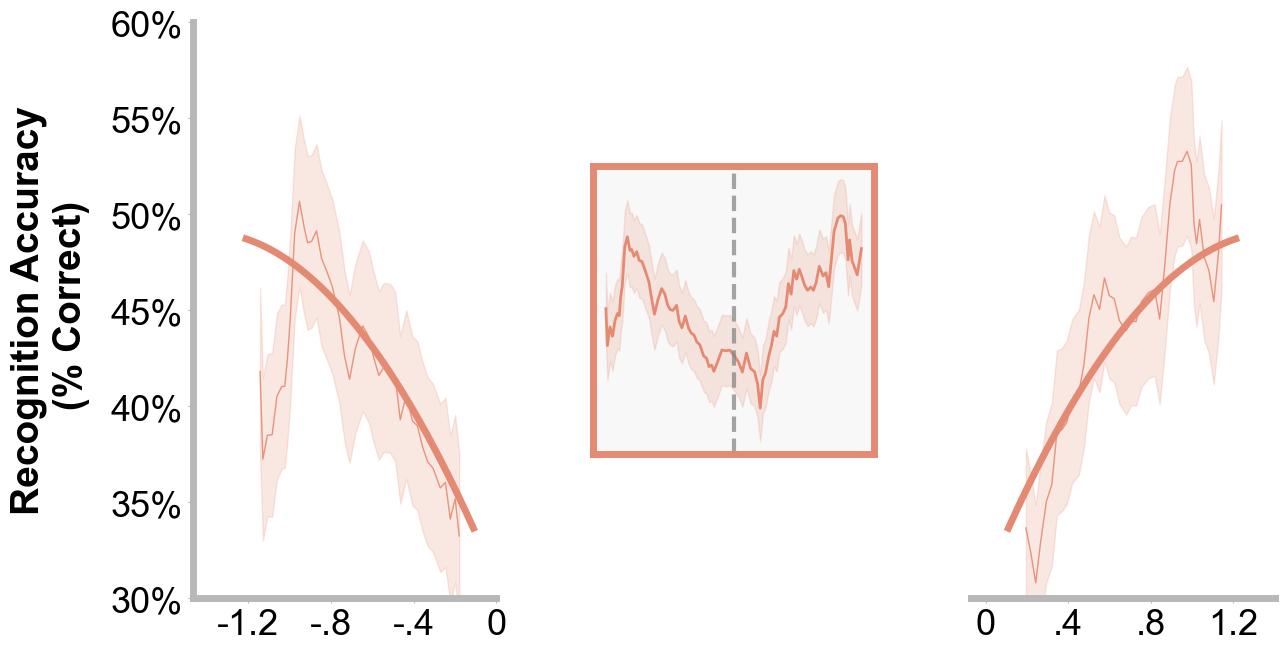

In [192]:
fig_it = create_single_row_visualization(
    plot_configs_it,  # Only first config will be plotted
    middle_width=0.35,
    middle_height_shift=0.05,
    middle_size_scale=0.5,
    adjustable_gap=-0.03,
    grey_out_models={0: {'right': False, 'left': False}},  # Now refers to the single row (row 0)
    x_buffer_percent=0.05
)


Row 0 - Fitting model to transformed (all positive) data:
  Total points: 4376
  Model order: 3
  X range before transform: [-0.169, 0.169]
  X range after transform: [0.007, 0.169]
  Model coefficients: [-183.0689535    53.0042975    -4.13791432    0.50289145]


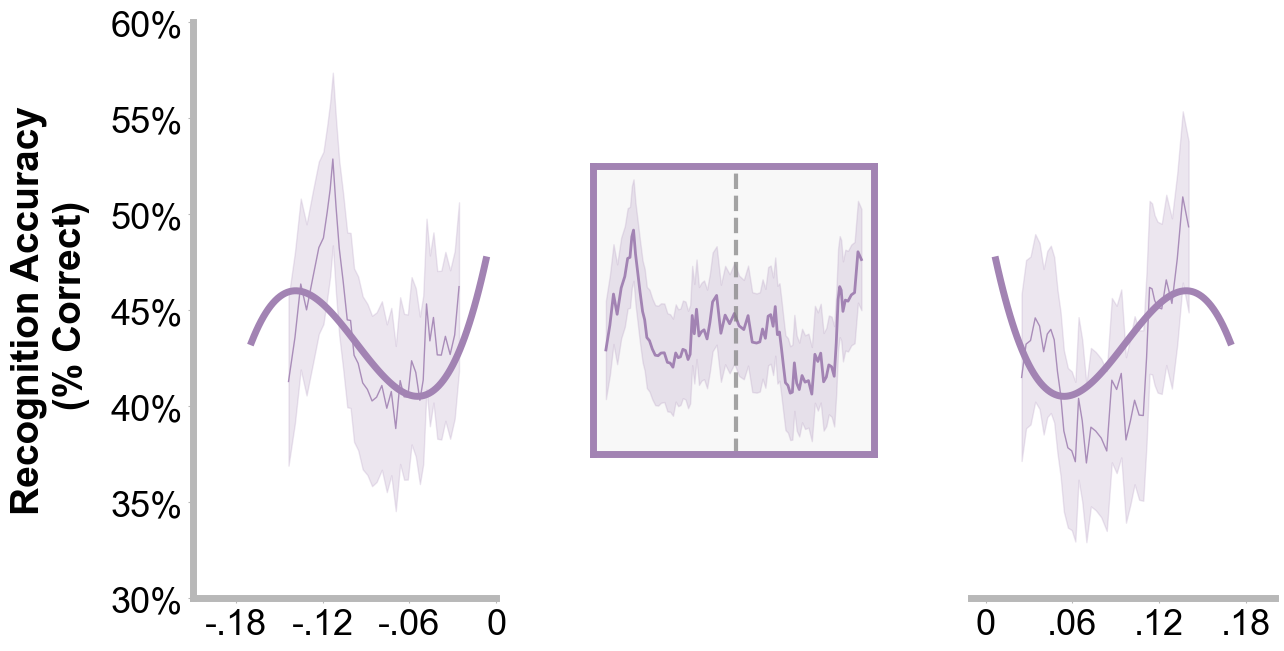

In [189]:

fig_v2 = create_single_row_visualization(
    plot_configs_v2,  # Only first config will be plotted
    middle_width=0.35,
    middle_height_shift=0.05,
    middle_size_scale=0.5,
    adjustable_gap=-0.03,
    # grey_out_models={0: {'right': False, 'left': False}},  # Now refers to the single row (row 0)
    x_buffer_percent=0.05
)